In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
np.set_printoptions(threshold=33500)
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, GeometryCollection
from shapely.ops import cascaded_union
import shapely.wkt
from shapely.validation import explain_validity,make_valid
from datetime import datetime, timedelta
from collections import OrderedDict
import fiona
from matplotlib.path import Path
from timezonefinder import TimezoneFinder
import pytz
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
viirs_all = pd.read_csv('merged_viirs.csv', dtype = {'satellite': str,'version': str, 'type': str})

In [3]:
viirs_all.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,31.36244,-101.77902,323.6,0.46,0.39,2019-12-04,842,1,VIIRS,n,2.0NRT,278.1,1.2,N,NaN
1,31.38544,-103.64748,298.0,0.40,0.37,2019-12-04,842,1,VIIRS,n,2.0NRT,271.1,0.6,N,NaN
2,31.80427,-104.12467,303.7,0.39,0.36,2019-12-04,842,1,VIIRS,n,2.0NRT,274.7,0.6,N,NaN
3,32.40633,-101.54912,315.3,0.46,0.39,2019-12-04,842,1,VIIRS,n,2.0NRT,276.2,1.6,N,NaN
4,31.80359,-104.12057,300.8,0.39,0.36,2019-12-04,842,1,VIIRS,n,2.0NRT,273.9,0.8,N,NaN


In [5]:
#incidents_all = pd.read_csv('unique_fires.csv')
#incidents_all = pd.read_csv('unique_fires_with_area.csv')
#incidents_all = pd.read_csv('unique_fires_with_area_and_irwin.csv')
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')

incidents_all = pd.concat([incidents_all, pd.DataFrame({'First Day UTC': np.zeros(len(incidents_all)),\
                                                'Last Day UTC': np.zeros(len(incidents_all)),\
                                               'Timezone': np.zeros(len(incidents_all))})], axis=1)
incidents_all['Fire Name'] = incidents_all['Fire Name'].str.upper() # make all fire names upper case so they can be easily searched

#put incident timezones into UTC
#NEED TO DEAL WITH TIME ZONES, based on location and time of year, from here: https://pypi.org/project/pytz/
for ii in range(len(incidents_all)):
    #print(incidents_all.iloc[ii:ii+1])
    obj=TimezoneFinder() #initialize the timezone finder
    tz = obj.timezone_at(lng=incidents_all['Lon Fire'].iloc[ii], lat=incidents_all['Lat Fire'].iloc[ii]) #get the timezone
    
    local = pytz.timezone(tz)
    utc = pytz.utc
    #put the start and end times in local time
    try:
        loc_dt_start = local.localize(datetime.strptime(incidents_all['First Day'].iloc[ii], '%Y-%m-%d %H:%M:%S'))
        loc_dt_end = local.localize(datetime.strptime(incidents_all['Last Day'].iloc[ii], '%Y-%m-%d'))
    except:
        dt_start = datetime.strptime(incidents_all['First Day'].iloc[ii], '%m/%d/%Y %I:%M:%S %p')
        #print(dt_start, datetime.strptime(datetime.strftime(dt_start,'%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S' ))
        
        loc_dt_start = local.localize(datetime.strptime(datetime.strftime(dt_start,'%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S' ))
        loc_dt_end = local.localize(datetime.strptime(incidents_all['Last Day'].iloc[ii], '%Y-%m-%d'))
        
    #put them in UTC time
    utc_dt_start = loc_dt_start.astimezone(utc)
    utc_dt_end = loc_dt_end.astimezone(utc)
        
    #reassign to UTC time, this DOES keep track of daylight savings (eg +7 is used for PDT, +8 is used for PST)
    incidents_all['First Day UTC'].iloc[ii] = str(utc_dt_start)[0:19]
    incidents_all['Last Day UTC'].iloc[ii] = str(utc_dt_end)[0:19]
    incidents_all['Timezone'].iloc[ii] = tz    
incidents_all

,Incident Number,irwinID,Fire Name,First Day,Last Day,Lat Fire,Lon Fire,Final Area (ac),First Day UTC,Last Day UTC,Timezone
0,10662156.0,['1DFCEE5C-8BE6-43BA-B3BB-12E8AC984221'],C34,2019-02-13 15:00:00,2019-02-15,36.995410,-102.524700,3812.1,2019-02-13 22:00:00,2019-02-15 07:00:00,America/Denver
1,10662179.0,['7D6CB9AB-F9A3-48B7-B0D7-ADEAD4D70E5F'],2161,2019-02-13 16:40:58,2019-02-14,35.221400,-101.518533,400.0,2019-02-13 22:40:58,2019-02-14 06:00:00,America/Chicago
2,10662684.0,['D7757D63-E7AB-4112-A782-2739EE07578E'],PAINTED WAGON,2019-04-08 13:02:00,2019-04-10,33.787040,-112.753300,384.0,2019-04-08 20:02:00,2019-04-10 07:00:00,America/Phoenix
3,10663171.0,['C7DC9B46-ACA3-49AE-AF91-3A84326FAFAA'],LONE MOUNTAIN,2019-05-26 23:56:00,2019-07-03,33.808056,-105.738600,3631.0,2019-05-27 05:56:00,2019-07-03 06:00:00,America/Denver
4,10663525.0,['C2B85F5F-CB24-4BF2-8480-CD2D8375AD87'],BOULDER,2019-06-05 12:45:00,2019-06-06,35.333056,-119.905556,1127.0,2019-06-05 19:45:00,2019-06-06 07:00:00,America/Los_Angeles
...,...,...,...,...,...,...,...,...,...,...,...
2069,13027985.0,['38EE1C28-9355-422E-9A4A-A8B9FA1EAD8D'],MEREDITH WAY,12/29/2021 5:45:00 PM,2021-12-30,35.656887,-101.603583,1.0,2021-12-29 23:45:00,2021-12-30 06:00:00,America/Chicago
2070,13028644.0,['C63FC371-BC70-4615-841B-B0838C21064F'],MARSHALL,12/30/2021 4:38:00 PM,2022-01-01,39.934350,-105.136200,6219.0,2021-12-30 23:38:00,2022-01-01 07:00:00,America/Denver
2071,13029092.0,['F27EAEA8-7F70-45E7-87BB-B332FB70566A'],NORTH WICHITA,12/15/2021 12:51:00 PM,2021-12-23,38.339940,-101.329900,782.0,2021-12-15 18:51:00,2021-12-23 06:00:00,America/Chicago
2072,13029117.0,['D1E1A129-8141-41F7-B01F-A782A9DD46D1'],WICHITA COUNTY,12/15/2021 2:28:00 PM,2021-12-23,38.601930,-101.175800,7572.0,2021-12-15 20:28:00,2021-12-23 06:00:00,America/Chicago


In [53]:
doot = '1:15 PM'
print(datetime.strptime(doot, "%H:%M %p"))

1900-01-01 01:15:00


In [45]:
m2 = '1:35 PM'
in_time = datetime.strptime(m2, "%I:%M %p")
print(in_time)
out_time = datetime.strftime(in_time, "%H:%M")
print(out_time)

1900-01-01 13:35:00
13:35


# Make the polygons for all the incidents

In [13]:
print(incidents_all[incidents_all['irwinID']=='3CC20E22-067F-463F-A602-5FC9AC59347E'])

Empty DataFrame
Columns: [Incident Number, irwinID, Fire Name, First Day, Last Day, Lat Fire, Lon Fire, Final Area (ac), First Day UTC, Last Day UTC, Timezone]
Index: []


In [6]:
incidents_all = incidents_all[incidents_all['Final Area (ac)']>1000].reset_index(drop=True) #filter to greater than 1000
incidents_all

,Incident Number,irwinID,Fire Name,First Day,Last Day,Lat Fire,Lon Fire,Final Area (ac),First Day UTC,Last Day UTC,Timezone
0,10662156.0,['1DFCEE5C-8BE6-43BA-B3BB-12E8AC984221'],C34,2019-02-13 15:00:00,2019-02-15,36.995410,-102.524700,3812.1,2019-02-13 22:00:00,2019-02-15 07:00:00,America/Denver
1,10663171.0,['C7DC9B46-ACA3-49AE-AF91-3A84326FAFAA'],LONE MOUNTAIN,2019-05-26 23:56:00,2019-07-03,33.808056,-105.738600,3631.0,2019-05-27 05:56:00,2019-07-03 06:00:00,America/Denver
2,10663525.0,['C2B85F5F-CB24-4BF2-8480-CD2D8375AD87'],BOULDER,2019-06-05 12:45:00,2019-06-06,35.333056,-119.905556,1127.0,2019-06-05 19:45:00,2019-06-06 07:00:00,America/Los_Angeles
3,10663845.0,['C12CF2DE-D490-4E26-B3F0-83CF775E168C'],CHANNING,2019-02-16 18:18:19,2019-02-17,35.655339,-102.323656,7527.4,2019-02-17 00:18:19,2019-02-17 06:00:00,America/Chicago
4,10664053.0,['C63B9519-E372-4B28-85AE-93AA89A377DC'],KEOTA,2019-03-19 16:25:00,2019-03-20,40.699040,-104.003000,1028.0,2019-03-19 22:25:00,2019-03-20 06:00:00,America/Denver
...,...,...,...,...,...,...,...,...,...,...,...
928,13027484.0,['C7240EC0-6E99-48C5-8295-966D3CAE9E8D'],WEST WIND,12/1/2021 8:43:00 AM,2021-12-06,47.278350,-110.170800,10644.0,2021-12-01 15:43:00,2021-12-06 07:00:00,America/Denver
929,13027777.0,['E4456E9A-05C5-4BD6-A59B-73BE8CCF203D'],TWIN CREEK,12/10/2021 2:57:11 PM,2021-12-13,35.659417,-101.871421,3607.0,2021-12-10 20:57:11,2021-12-13 06:00:00,America/Chicago
930,13028644.0,['C63FC371-BC70-4615-841B-B0838C21064F'],MARSHALL,12/30/2021 4:38:00 PM,2022-01-01,39.934350,-105.136200,6219.0,2021-12-30 23:38:00,2022-01-01 07:00:00,America/Denver
931,13029117.0,['D1E1A129-8141-41F7-B01F-A782A9DD46D1'],WICHITA COUNTY,12/15/2021 2:28:00 PM,2021-12-23,38.601930,-101.175800,7572.0,2021-12-15 20:28:00,2021-12-23 06:00:00,America/Chicago


In [7]:
#incidents_all = incidents_all[incidents_all['Fire Name']=='SCU LIGHTNING COMPLEX']
#incidents_all['Lat Fire'] = 37.439437
#incidents_all['Lon Fire'] = -121.30435

first_days=np.array(incidents_all['First Day UTC'].values, dtype='datetime64')
incidents_all = incidents_all[(first_days>=np.datetime64('2019-07-01'))&
                              (first_days<=np.datetime64('2020-01-01'))].reset_index(drop=True) # SELECT 2020 fires

incidents_all

,Incident Number,irwinID,Fire Name,First Day,Last Day,Lat Fire,Lon Fire,Final Area (ac),First Day UTC,Last Day UTC,Timezone
0,10669846.0,['A887CF9D-CB2F-4CC8-9499-79730B6F8FF7'],NARANJO,2019-07-03 16:47:00,2019-07-18,36.157040,-106.923500,1010.0,2019-07-03 22:47:00,2019-07-18 06:00:00,America/Denver
1,10671263.0,['5AE90462-0FF1-44A8-95BC-475EB464F948'],FRANCISQUITO,2019-07-13 16:42:00,2019-07-21,36.449444,-106.206900,2021.0,2019-07-13 22:42:00,2019-07-21 06:00:00,America/Denver
2,10671372.0,['A27E2450-FF64-4588-BA00-91E8BDA7DD00'],HEART,2019-07-14 17:08:00,2019-07-16,44.144000,-116.691900,1529.0,2019-07-14 23:08:00,2019-07-16 06:00:00,America/Boise
3,10671438.0,['92A45D96-AFE1-458B-8B6B-45291DDD4744'],CELLAR,2019-07-14 16:25:00,2019-07-29,34.243170,-112.487400,7512.0,2019-07-14 23:25:00,2019-07-29 07:00:00,America/Phoenix
4,10672460.0,['444AD575-C2EB-4A5D-9710-18E6EA6FED44'],BUFFALO CORRAL,2019-07-14 18:13:00,2019-07-16,31.562430,-110.376400,1178.0,2019-07-15 01:13:00,2019-07-16 07:00:00,America/Phoenix
...,...,...,...,...,...,...,...,...,...,...,...
165,10804162.0,['12D435C8-627E-438F-994A-1105E5DBB56F'],TENAJA,2019-09-04 17:57:36,2019-09-14,33.528469,-117.273157,1926.0,2019-09-05 00:57:36,2019-09-14 07:00:00,America/Los_Angeles
166,10804827.0,['4410E61B-2868-46DD-A657-16945FC9FAE5'],WARD,2019-08-09 15:22:00,2019-08-20,42.032500,-122.175300,1301.0,2019-08-09 22:22:00,2019-08-20 07:00:00,America/Los_Angeles
167,10805233.0,['5FE21DAF-EDC3-4D6D-9ECA-2A4F9BB5A440'],BUNTING,2019-08-10 10:46:00,2019-08-13,47.557188,-108.004408,1168.0,2019-08-10 16:46:00,2019-08-13 06:00:00,America/Denver
168,10805427.0,['6FB0FEFD-A96D-4F23-BD34-60936BFCD93F'],204 COW,2019-08-09 21:34:00,2019-10-20,44.285050,-118.459800,9668.0,2019-08-10 04:34:00,2019-10-20 07:00:00,America/Los_Angeles


In [7]:
incidents_all = incidents_all.iloc[np.where((incidents_all['Fire Name']=='BARREN HILL'))]#|
#                                            (incidents_all['Fire Name']=='CZU AUG LIGHTNING'))]
incidents_all

,Incident Number,irwinID,Fire Name,First Day,Last Day,Lat Fire,Lon Fire,Final Area (ac),First Day UTC,Last Day UTC,Timezone
126,10773154.0,['659B5E49-52DE-4A6B-9EC6-CD2F0D095DC8'],BARREN HILL,2019-07-01 14:52:00,2019-10-31,46.236833,-114.982833,1592.0,2019-07-01 21:52:00,2019-10-31 07:00:00,America/Los_Angeles


### Original Way to Get Polygons

In [71]:
#ALL PER OVERPASS FOR NOW

incident_numbers = incidents_all['Incident Number'].values
print(incident_numbers)
fire_poly_timeseries_all = gpd.GeoDataFrame()

for ii in range(len(incidents_all)):
    print(incidents_all['Fire Name'].iloc[ii])
    
    inci = incidents_all[incidents_all['Incident Number']==incident_numbers[ii]].iloc[0]
    df_save_size = count_overpasses(inci,viirs_all) #count the overpasses between fire start and end date
    
    area = 0
    final_area = inci['Final Area (ac)']
    idx = 0
    #radii_test = [0.01,0.05,0.1,0.25]
    #radii_test=[0.1,0.15,0.2]
    radii_test = [0.25]
    
    while (area<0.75*final_area) & (idx<len(radii_test)):
        print(idx)
        rad_test = radii_test[idx]
        fire_poly_timeseries = build_polygon_timeseries(df_save_size,inci,rad_test)

        if len(fire_poly_timeseries)>0:

            fire_poly_timeseries.crs = "EPSG:4326"
            fire_poly_timeseries = fire_poly_timeseries.to_crs(epsg=3347) #put into lambert conformal conic

            #make sure the returned polygons are valid
            fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x, rounding_precision=4)))
            fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].buffer(0)
            #fire_poly_timeseries['geometry'].apply(lambda z: print(explain_validity(z)))
            fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].apply(lambda y: make_valid(y))
            fire_poly_timeseries['daily_area'] = fire_poly_timeseries.area/4047 #area in acres
            
            area=fire_poly_timeseries['daily_area'].sum()
            idx=idx+1
            #print(area, final_area)
    
    """fire_poly_timeseries_plot = fire_poly_timeseries.to_crs('EPSG:4326')

    fig = plt.figure(figsize=(15,10))
    ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
    #ax.set_extent([-124, -122, 39.2,40.5])
    fire_poly_timeseries_plot.plot(column = fire_poly_timeseries['Current Day'], ax=ax, cmap='OrRd', legend=True)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
                        linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    plt.title(incidents_all['Fire Name'].iloc[ii]+ ' With Per Overpass Polygons')
    plt.show()"""

    #fire_poly_timeseries.set_geometry(col='geometry', inplace=True) #assign a column to represent geometry
    #fire_poly_timeseries.to_file(fire_incidents[ii].lower().replace(' ', '_')+'_VIIRS_per_overpass_2.geojson', driver='GeoJSON')

    print(fire_poly_timeseries)
    fire_poly_timeseries_all = pd.concat([fire_poly_timeseries_all, fire_poly_timeseries],axis=0)
print(fire_poly_timeseries_all)
#fire_poly_timeseries_all.to_file('AllFires_VIIRS_per_overpass_irwin_2019.geojson', driver='GeoJSON')
#fire_poly_timeseries_all.to_file('scu_VIIRS_per_overpass_2020.geojson', driver='GeoJSON')
fire_poly_timeseries_all.to_file('AllFires_VIIRS_per_overpass_irwin_2021.geojson', driver='GeoJSON')


[12688717. 12690152. 12692458. 12692752. 12695100. 12695676. 12697874.
 12699246. 12699297. 12701714. 12701755. 12702824. 12705279. 12708835.
 12712456. 12712564. 12712637. 12712968. 12727654. 12729036. 12731832.
 12733059. 12733223. 12736289. 12740094. 12744293. 12747510. 12753082.
 12756685. 12759412. 12759732. 12760213. 12761368. 12761451. 12761859.
 12764062. 12764269. 12765224. 12766548. 12768005. 12780327. 12783237.
 12783532. 12783620. 12783884. 12785796. 12789386. 12790078. 12791608.
 12795774. 12796824. 12800234. 12802538. 12802650. 12802924. 12805165.
 12807244. 12808035. 12808203. 12811043. 12811840. 12812313. 12813401.
 12813617. 12815823. 12818714. 12821423. 12821468. 12821712. 12822141.
 12827944. 12828308. 12832075. 12835608. 12839107. 12839629. 12839678.
 12839928. 12841669. 12842569. 12843070. 12846055. 12848646. 12849422.
 12850723. 12862144. 12862522. 12863927. 12864811. 12865789. 12867063.
 12867472. 12894697. 12895400. 12895839. 12908560. 12916348. 12917694.
 12918

2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05
2021-09-06
2021-09-07
2021-09-08
2021-09-09
2021-09-10
2021-09-11
2021-09-12
2021-09-13
2021-09-14
2021-09-15
2021-09-16
618 seconds seconds elapsed
     Incident Number                               irwinID  Fire Name  \
0         12690152.0  938686BB-0F52-47B2-B077-EB307941D939  MCFARLAND   
1         12690152.0  938686BB-0F52-47B2-B077-EB307941D939  MCFARLAND   
2         12690152.0  938686BB-0F52-47B2-B077-EB307941D939  MCFARLAND   
3         12690152.0  938686BB-0F52-47B2-B077-EB307941D939  MCFARLAND   
4         12690152.0  938686BB-0F52-47B2-B077-EB307941D939  MCFARLAND   
..               ...                                   ...        ...   
309       12690152.0  938686BB-0F52-47B2-B077-EB307941D939  MCFARLAND   
310       12690152.0  938

2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05
2021-09-06
2021-09-07
2021-09-08
2021-09-09
2021-09-10
2021-09-11
2021-09-12
2021-09-13
2021-09-14
2021-09-15
2021-09-16
2021-09-17
2021-09-18
2021-09-19
2021-09-20
2021-09-21
2021-09-22
2021-09-23
2021-09-24
2021-09-25
2021-09-26
2021-09-27
2021-09-28
2021-09-29
2021-09-30
2021-10-01
2021-10-02
2021-10-03
2021-10-04
2021-10-05
2021-10-06
2021-10-07
2021-10-08
2021-10-09
2021-10-10
2021-10-11
2021-10-12
2021-10-13
2021-10-14
66 seconds seconds elapsed
     Incident Number                               irwinID  \
0         12692752.0  41006EDD-58D9-46AB-91B1-139280807391   
1         12692752.0  41006EDD-58D9-46AB-91B1-139280807391   
2     

     Incident Number                               irwinID       Fire Name  \
0         12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   
1         12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   
2         12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   
3         12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   
4         12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   
..               ...                                   ...             ...   
143       12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   
144       12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   
145       12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   
146       12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   
147       12695676.0  A6A8BC3B-BEE1-449F-80AF-D58F6E3F7FCE  DIVIDE COMPLEX   

    Current Day  Current Overpass   Lat Fire  Lon Fire  \
0    

0
['2021-07-10' '2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14'
 '2021-07-15' '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19'
 '2021-07-20' '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24'
 '2021-07-25' '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29'
 '2021-07-30' '2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03'
 '2021-08-04' '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08'
 '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13'
 '2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18'
 '2021-08-19' '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23'
 '2021-08-24' '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28'
 '2021-08-29' '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02'
 '2021-09-03' '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07'
 '2021-09-08' '2021-09-09' '2021-09-10' '2021-09-11' '2021-09-12'
 '2021-09-13' '2021-09-14' '2021-09-15' '2021-09-16' '2021-09-17'
 '2021-09-18' '2021-09-19' '2021-09-20' '2021-09-21' '2021-09-22'
 '2021-0

0
['2021-07-09' '2021-07-10' '2021-07-11' '2021-07-12' '2021-07-13'
 '2021-07-14' '2021-07-15' '2021-07-16' '2021-07-17' '2021-07-18'
 '2021-07-19' '2021-07-20' '2021-07-21' '2021-07-22' '2021-07-23'
 '2021-07-24' '2021-07-25' '2021-07-26' '2021-07-27' '2021-07-28'
 '2021-07-29' '2021-07-30' '2021-07-31' '2021-08-01' '2021-08-02'
 '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06' '2021-08-07'
 '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12'
 '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17'
 '2021-08-18' '2021-08-19']
2021-07-09
2021-07-10
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021-08-03
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
20

0
['2021-07-07' '2021-07-08' '2021-07-09' '2021-07-10' '2021-07-11'
 '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16'
 '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21'
 '2021-07-22']
2021-07-07
2021-07-08
2021-07-09
2021-07-10
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
1 seconds seconds elapsed
    Incident Number                               irwinID Fire Name  \
0        12705279.0  F1B3DE00-D58E-40FF-AF91-CE3C84389F80   FIREBOX   
1        12705279.0  F1B3DE00-D58E-40FF-AF91-CE3C84389F80   FIREBOX   
2        12705279.0  F1B3DE00-D58E-40FF-AF91-CE3C84389F80   FIREBOX   
3        12705279.0  F1B3DE00-D58E-40FF-AF91-CE3C84389F80   FIREBOX   
4        12705279.0  F1B3DE00-D58E-40FF-AF91-CE3C84389F80   FIREBOX   
5        12705279.0  F1B3DE00-D58E-40FF-AF91-CE3C84389F80   FIREBOX   
6        12705279.0  F1B3DE00-D58E-40FF-AF91-CE3C84389F80   FIREBOX   
7        127052

0
['2021-07-07' '2021-07-08' '2021-07-09' '2021-07-10' '2021-07-11'
 '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16'
 '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21'
 '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26'
 '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31'
 '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05'
 '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10'
 '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15'
 '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20'
 '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25'
 '2021-08-26' '2021-08-27' '2021-08-28']
2021-07-07
2021-07-08
2021-07-09
2021-07-10
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02


0
['2021-07-07' '2021-07-08' '2021-07-09' '2021-07-10' '2021-07-11'
 '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16'
 '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21'
 '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26'
 '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31'
 '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05'
 '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10'
 '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15'
 '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20'
 '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25'
 '2021-08-26' '2021-08-27' '2021-08-28']
2021-07-07
2021-07-08
2021-07-09
2021-07-10
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02


['2021-07-07' '2021-07-08' '2021-07-09' '2021-07-10']
2021-07-07
2021-07-08
2021-07-09
2021-07-10
0 seconds seconds elapsed
    Incident Number                               irwinID Fire Name  \
0        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
1        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
2        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
3        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
4        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
5        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
6        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
7        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
8        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
9        12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
10       12731832.0  21C8043B-736B-46A9-A131-C02E4A3221FE     SCOTT   
11       12731832.0  21C

0
['2021-07-09' '2021-07-10' '2021-07-11' '2021-07-12' '2021-07-13'
 '2021-07-14' '2021-07-15' '2021-07-16' '2021-07-17' '2021-07-18'
 '2021-07-19' '2021-07-20' '2021-07-21' '2021-07-22' '2021-07-23'
 '2021-07-24' '2021-07-25' '2021-07-26' '2021-07-27' '2021-07-28'
 '2021-07-29' '2021-07-30' '2021-07-31' '2021-08-01' '2021-08-02'
 '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06' '2021-08-07'
 '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12'
 '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17'
 '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21' '2021-08-22'
 '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26' '2021-08-27'
 '2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31' '2021-09-01'
 '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05' '2021-09-06'
 '2021-09-07' '2021-09-08' '2021-09-09' '2021-09-10' '2021-09-11'
 '2021-09-12' '2021-09-13' '2021-09-14' '2021-09-15' '2021-09-16'
 '2021-09-17' '2021-09-18' '2021-09-19' '2021-09-20' '2021-09-21'
 '2021-0

0
['2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15'
 '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25'
 '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30'
 '2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04'
 '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09'
 '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24'
 '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03'
 '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08'
 '2021-09-09' '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13'
 '2021-09-14' '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18'
 '2021-09-19' '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23'
 '2021-0

0
['2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15'
 '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25'
 '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30'
 '2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04'
 '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09'
 '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24'
 '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03'
 '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08'
 '2021-09-09' '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13'
 '2021-09-14' '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18'
 '2021-09-19' '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23'
 '2021-0

0
['2021-07-03' '2021-07-04' '2021-07-05' '2021-07-06' '2021-07-07'
 '2021-07-08' '2021-07-09' '2021-07-10' '2021-07-11' '2021-07-12'
 '2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16' '2021-07-17'
 '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21' '2021-07-22'
 '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26' '2021-07-27'
 '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31' '2021-08-01'
 '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06'
 '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11'
 '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16'
 '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21'
 '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26'
 '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31'
 '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05'
 '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09' '2021-09-10'
 '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14' '2021-09-15'
 '2021-0

['2021-07-03' '2021-07-04' '2021-07-05']
2021-07-03
2021-07-04
2021-07-05
0 seconds seconds elapsed
   Incident Number                               irwinID     Fire Name  \
0       12761368.0  3E829C9B-5950-446C-8494-717F0AD020B0  INSIDE LAKES   
1       12761368.0  3E829C9B-5950-446C-8494-717F0AD020B0  INSIDE LAKES   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-07-03             730.0  42.32479 -115.5639   
1  2021-07-03            2130.0  42.32479 -115.5639   

   Number of NEW VIIRS points  NEW FRP  \
0                         0.0      0.0   
1                         9.0    189.1   

                                            geometry  daily_area  
0  POLYGON ((4231968.663 1047022.283, 4231960.785...   23.460982  
1  MULTIPOLYGON (((4231503.592 1046817.837, 42314...  211.157255  
ELKHORN
<class 'str'>
0
['2021-07-03' '2021-07-04' '2021-07-05' '2021-07-06' '2021-07-07'
 '2021-07-08' '2021-07-09']
2021-07-03
2021-07-04
2021-07-05
2021-07-06
2021-07-07
2021-07-08

2021-07-09
2021-07-10
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2 seconds seconds elapsed
    Incident Number                               irwinID   Fire Name  \
0        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
1        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
2        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
3        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
4        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
5        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
6        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
7        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
8        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
9        12765224.0  49841930-72CA-459A-AEBE-68E09F347456  TOO KUSH 2   
10       12765224.0  4984193

0
['2021-07-01' '2021-07-02' '2021-07-03' '2021-07-04' '2021-07-05'
 '2021-07-06' '2021-07-07' '2021-07-08' '2021-07-09' '2021-07-10'
 '2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15'
 '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25'
 '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30'
 '2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04'
 '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09'
 '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24'
 '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03'
 '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08'
 '2021-09-09']
2021-07-01
2021-07-02
2021-07-03
2021-07-04
2021-07-05
2021

0
['2021-07-05' '2021-07-06' '2021-07-07' '2021-07-08' '2021-07-09'
 '2021-07-10' '2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14'
 '2021-07-15' '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19'
 '2021-07-20' '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24'
 '2021-07-25' '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29'
 '2021-07-30' '2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03'
 '2021-08-04' '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08'
 '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13'
 '2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18'
 '2021-08-19' '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23'
 '2021-08-24' '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28'
 '2021-08-29' '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02'
 '2021-09-03' '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07'
 '2021-09-08' '2021-09-09' '2021-09-10' '2021-09-11' '2021-09-12'
 '2021-09-13' '2021-09-14' '2021-09-15' '2021-09-16' '2021-09-17'
 '2021-0

['2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21' '2021-07-22']
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
0 seconds seconds elapsed
    Incident Number                               irwinID Fire Name  \
0        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
1        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
2        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
3        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
4        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
5        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
6        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
7        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
8        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
9        12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   
10       12783532.0  9E21FDA1-3DEA-4DD6-9243-DD7383A571BE  SAW MILL   


0
['2021-07-06' '2021-07-07' '2021-07-08' '2021-07-09' '2021-07-10'
 '2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15'
 '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25'
 '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30'
 '2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04'
 '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09'
 '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24'
 '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03'
 '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08'
 '2021-09-09' '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13'
 '2021-09-14' '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18'
 '2021-0

0
['2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05'
 '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10'
 '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15'
 '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20'
 '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25'
 '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30'
 '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04'
 '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09'
 '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14'
 '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18' '2021-09-19'
 '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23' '2021-09-24'
 '2021-09-25' '2021-09-26' '2021-09-27' '2021-09-28' '2021-09-29'
 '2021-09-30' '2021-10-01' '2021-10-02' '2021-10-03' '2021-10-04'
 '2021-10-05' '2021-10-06' '2021-10-07' '2021-10-08' '2021-10-09'
 '2021-10-10' '2021-10-11' '2021-10-12' '2021-10-13' '2021-10-14'
 '2021-1

0
['2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25'
 '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30'
 '2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04'
 '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09'
 '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24'
 '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03'
 '2021-09-04' '2021-09-05' '2021-09-06']
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021-08-03
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11


0
['2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16' '2021-07-17'
 '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21' '2021-07-22'
 '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26' '2021-07-27'
 '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31' '2021-08-01'
 '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06'
 '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11'
 '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16'
 '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21'
 '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26'
 '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31'
 '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05'
 '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09' '2021-09-10'
 '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14' '2021-09-15'
 '2021-09-16' '2021-09-17' '2021-09-18' '2021-09-19' '2021-09-20'
 '2021-09-21' '2021-09-22' '2021-09-23' '2021-09-24' '2021-09-25'
 '2021-0

2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05
2021-09-06
2021-09-07
2021-09-08
2021-09-09
2021-09-10
2021-09-11
2021-09-12
2021-09-13
2021-09-14
2021-09-15
2021-09-16
2021-09-17
2021-09-18
2021-09-19
2021-09-20
2021-09-21
2021-09-22
2021-09-23
2021-09-24
2021-09-25
2021-09-26
2021-09-27
2021-09-28
2021-09-29
2021-09-30
2021-10-01
2021-10-02
2021-10-03
2021-10-04
2021-10-05
2021-10-06
2021-10-07
2021-10-08
2021-10-09
2021-10-10
2021-10-11
2021-10-12
2021-10-13
2021-10-14
143 seconds seconds elapsed
     Incident Number                               irwinID   Fire Name  \
0         12802650.0  63FFB3A1-2BC3-4E08-9C97-B17F9A05F22B  RUSH CREEK   
1         12802650.0  63FFB3A1-2BC3-4E08-9C97-B17F9A05F22B  RUSH CREEK   
2         12802650.0  63FFB3A1-2BC3-4E08-9C97-B17F9A05F22B  RUSH CREEK   
3         12802650.0  63FFB3A1-2BC3-4E08-9C97-B17F9A05F22B  RUSH CREEK   
4         12802650.0  63FFB3A1-2BC3-4E08-9C97-B17F9A05F22B  RUSH CREEK   
..               ...                        

0
['2021-07-06' '2021-07-07' '2021-07-08' '2021-07-09' '2021-07-10'
 '2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15'
 '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25'
 '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30'
 '2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04'
 '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09'
 '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14']
2021-07-06
2021-07-07
2021-07-08
2021-07-09
2021-07-10
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021-08-03
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
486 seconds seconds elapsed
 

0
['2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21'
 '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26'
 '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31'
 '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05'
 '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10'
 '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15'
 '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20'
 '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25'
 '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30'
 '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04'
 '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09'
 '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14'
 '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18' '2021-09-19'
 '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23' '2021-09-24'
 '2021-09-25' '2021-09-26' '2021-09-27' '2021-09-28' '2021-09-29'
 '2021-0

0
['2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21'
 '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26'
 '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31'
 '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05'
 '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10'
 '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15'
 '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20'
 '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25'
 '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30'
 '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04'
 '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09'
 '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14'
 '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18' '2021-09-19'
 '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23' '2021-09-24'
 '2021-09-25' '2021-09-26' '2021-09-27' '2021-09-28' '2021-09-29'
 '2021-0

0
['2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21'
 '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26'
 '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31'
 '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05'
 '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10'
 '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15'
 '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20'
 '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25'
 '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30'
 '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04'
 '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09']
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021-08-03
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08

0
['2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21'
 '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26'
 '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31'
 '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05'
 '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10'
 '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15'
 '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20'
 '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25'
 '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30'
 '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04'
 '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09'
 '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14'
 '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18' '2021-09-19'
 '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23' '2021-09-24'
 '2021-09-25' '2021-09-26' '2021-09-27' '2021-09-28' '2021-09-29'
 '2021-0

2021-10-21
2021-10-22
2021-10-23
2021-10-24
2021-10-25
2021-10-26
2021-10-27
2021-10-28
2021-10-29
2021-10-30
2021-10-31
2021-11-01
2021-11-02
2021-11-03
2021-11-04
2021-11-05
2021-11-06
2021-11-07
2021-11-08
2021-11-09
2021-11-10
2021-11-11
2021-11-12
2021-11-13
2021-11-14
2021-11-15
2021-11-16
2021-11-17
2021-11-18
2021-11-19
2021-11-20
2021-11-21
2021-11-22
2021-11-23
2021-11-24
2021-11-25
2021-11-26
2021-11-27
2021-11-28
2021-11-29
2021-11-30
2021-12-01
2021-12-02
2021-12-03
2021-12-04
2021-12-05
2021-12-06
2021-12-07
2021-12-08
2021-12-09
2021-12-10
2021-12-11
2021-12-12
2021-12-13
2021-12-14
2021-12-15
2021-12-16
2021-12-17
2021-12-18
2021-12-19
2021-12-20
2021-12-21
2021-12-22
2021-12-23
2021-12-24
2021-12-25
2021-12-26
2021-12-27
2021-12-28
2021-12-29
2021-12-30
579 seconds seconds elapsed
     Incident Number                               irwinID  \
0         12815823.0  B9B83DBE-921D-4D4B-A9C7-68710B29283D   
1         12815823.0  B9B83DBE-921D-4D4B-A9C7-68710B29283D   
2    

['2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13']
2021-09-10
2021-09-11
2021-09-12
2021-09-13
0 seconds seconds elapsed
    Incident Number                               irwinID Fire Name  \
0        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
1        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
2        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
3        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
4        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
5        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
6        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
7        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
8        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
9        12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
10       12821423.0  BA2C4EC7-36BF-4B79-B6D1-8706200326BF    COLONY   
11       12821423.0  BA2

0
['2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14'
 '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18' '2021-09-19'
 '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23' '2021-09-24'
 '2021-09-25' '2021-09-26' '2021-09-27' '2021-09-28' '2021-09-29'
 '2021-09-30' '2021-10-01' '2021-10-02' '2021-10-03' '2021-10-04'
 '2021-10-05' '2021-10-06' '2021-10-07']
2021-09-10
2021-09-11
2021-09-12
2021-09-13
2021-09-14
2021-09-15
2021-09-16
2021-09-17
2021-09-18
2021-09-19
2021-09-20
2021-09-21
2021-09-22
2021-09-23
2021-09-24
2021-09-25
2021-09-26
2021-09-27
2021-09-28
2021-09-29
2021-09-30
2021-10-01
2021-10-02
2021-10-03
2021-10-04
2021-10-05
2021-10-06
2021-10-07
1 seconds seconds elapsed
    Incident Number                               irwinID Fire Name  \
0        12822141.0  5E81D8CF-317C-44A4-BDD7-E84EE627771C    LEGACY   
1        12822141.0  5E81D8CF-317C-44A4-BDD7-E84EE627771C    LEGACY   
2        12822141.0  5E81D8CF-317C-44A4-BDD7-E84EE627771C    LEGACY   
3        

2021-09-14
2021-09-15
2021-09-16
2021-09-17
2021-09-18
2021-09-19
2021-09-20
2021-09-21
2021-09-22
2021-09-23
2021-09-24
2021-09-25
2021-09-26
2021-09-27
2021-09-28
2021-09-29
2021-09-30
2021-10-01
2021-10-02
2021-10-03
2021-10-04
2021-10-05
2021-10-06
2021-10-07
2021-10-08
2021-10-09
2021-10-10
2021-10-11
2021-10-12
2021-10-13
2021-10-14
2021-10-15
2021-10-16
2021-10-17
2021-10-18
2021-10-19
2021-10-20
2021-10-21
2021-10-22
2021-10-23
2021-10-24
2021-10-25
2021-10-26
2021-10-27
2021-10-28
2021-10-29
2021-10-30
2021-10-31
2021-11-01
2021-11-02
2021-11-03
2021-11-04
2021-11-05
2021-11-06
2021-11-07
2021-11-08
2021-11-09
2021-11-10
2021-11-11
2021-11-12
2021-11-13
2021-11-14
2021-11-15
2021-11-16
2021-11-17
2021-11-18
2021-11-19
2021-11-20
2021-11-21
2021-11-22
2021-11-23
2021-11-24
2021-11-25
2021-11-26
2021-11-27
2021-11-28
2021-11-29
2021-11-30
2021-12-01
2021-12-02
2021-12-03
2021-12-04
2021-12-05
2021-12-06
2021-12-07
2021-12-08
2021-12-09
2021-12-10
2021-12-11
2021-12-12
2021-12-13

0
['2021-07-08' '2021-07-09' '2021-07-10' '2021-07-11' '2021-07-12'
 '2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16' '2021-07-17'
 '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21' '2021-07-22'
 '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26' '2021-07-27'
 '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31' '2021-08-01'
 '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06'
 '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11'
 '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16'
 '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21'
 '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26'
 '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31'
 '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05'
 '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09' '2021-09-10'
 '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14' '2021-09-15'
 '2021-09-16' '2021-09-17' '2021-09-18' '2021-09-19' '2021-09-20'
 '2021-0

0
['2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15'
 '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25'
 '2021-07-26']
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
1 seconds seconds elapsed
    Incident Number                               irwinID Fire Name  \
0        12839629.0  85CDABDE-E8D4-4015-93DA-273288553E92  LONESOME   
1        12839629.0  85CDABDE-E8D4-4015-93DA-273288553E92  LONESOME   
2        12839629.0  85CDABDE-E8D4-4015-93DA-273288553E92  LONESOME   
3        12839629.0  85CDABDE-E8D4-4015-93DA-273288553E92  LONESOME   
4        12839629.0  85CDABDE-E8D4-4015-93DA-273288553E92  LONESOME   
..              ...                                   ...       ...   
64       12839629.0  85CDABDE-E8D4-4015-93DA-273288553E92  LONESOME   
65       128396

['2021-10-12' '2021-10-13']
2021-10-12
2021-10-13
0 seconds seconds elapsed
   Incident Number                               irwinID Fire Name  \
0       12841669.0  A77BC970-5FD4-46C9-9C2D-53702CFB2DA7   MAVRICK   
1       12841669.0  A77BC970-5FD4-46C9-9C2D-53702CFB2DA7   MAVRICK   
2       12841669.0  A77BC970-5FD4-46C9-9C2D-53702CFB2DA7   MAVRICK   

  Current Day  Current Overpass   Lat Fire  Lon Fire  \
0  2021-10-12             742.0  31.578411 -110.4085   
1  2021-10-12             837.0  31.578411 -110.4085   
2  2021-10-12             924.0  31.578411 -110.4085   

   Number of NEW VIIRS points  NEW FRP  \
0                         0.0     0.00   
1                        21.0   254.47   
2                        21.0   135.24   

                                            geometry  daily_area  
0  POLYGON ((4280820.418 -313506.920, 4280813.474...   31.023577  
1  MULTIPOLYGON (((4284743.926 -310851.442, 42847...  640.849269  
2  MULTIPOLYGON (((4285609.796 -310625.515, 4285

0
['2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15'
 '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21']
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
1 seconds seconds elapsed
   Incident Number                               irwinID Fire Name  \
0       12846055.0  6C637E6B-6609-45D0-BED7-C75756A63B05  OCOTILLO   
1       12846055.0  6C637E6B-6609-45D0-BED7-C75756A63B05  OCOTILLO   
2       12846055.0  6C637E6B-6609-45D0-BED7-C75756A63B05  OCOTILLO   
3       12846055.0  6C637E6B-6609-45D0-BED7-C75756A63B05  OCOTILLO   
4       12846055.0  6C637E6B-6609-45D0-BED7-C75756A63B05  OCOTILLO   
5       12846055.0  6C637E6B-6609-45D0-BED7-C75756A63B05  OCOTILLO   
6       12846055.0  6C637E6B-6609-45D0-BED7-C75756A63B05  OCOTILLO   
7       12846055.0  6C637E6B-6609-45D0-BED7-C75756A63B05  OCOTILLO   
8       12846055.0  6C637E6B-6609-45D0-BED7-C75756A63B05  OCOTILLO   

  C

['2021-10-26' '2021-10-27' '2021-10-28']
2021-10-26
2021-10-27
2021-10-28
0 seconds seconds elapsed
   Incident Number                               irwinID Fire Name  \
0       12862144.0  D9B1B980-C845-4E0D-B22C-CDAA89FF02E9      BLUE   
1       12862144.0  D9B1B980-C845-4E0D-B22C-CDAA89FF02E9      BLUE   
2       12862144.0  D9B1B980-C845-4E0D-B22C-CDAA89FF02E9      BLUE   
3       12862144.0  D9B1B980-C845-4E0D-B22C-CDAA89FF02E9      BLUE   
4       12862144.0  D9B1B980-C845-4E0D-B22C-CDAA89FF02E9      BLUE   

  Current Day  Current Overpass  Lat Fire   Lon Fire  \
0  2021-10-26             731.0  35.84245 -101.97397   
1  2021-10-26             818.0  35.84245 -101.97397   
2  2021-10-26             911.0  35.84245 -101.97397   
3  2021-10-28             835.0  35.84245 -101.97397   
4  2021-10-28             924.0  35.84245 -101.97397   

   Number of NEW VIIRS points  NEW FRP  \
0                         2.0     9.81   
1                         1.0     5.03   
2               

0
['2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10'
 '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15'
 '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20'
 '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25'
 '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30'
 '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04'
 '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09'
 '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14'
 '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18' '2021-09-19'
 '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23' '2021-09-24'
 '2021-09-25' '2021-09-26' '2021-09-27' '2021-09-28' '2021-09-29'
 '2021-09-30' '2021-10-01' '2021-10-02' '2021-10-03' '2021-10-04'
 '2021-10-05' '2021-10-06' '2021-10-07' '2021-10-08' '2021-10-09'
 '2021-10-10' '2021-10-11' '2021-10-12' '2021-10-13' '2021-10-14'
 '2021-10-15' '2021-10-16' '2021-10-17' '2021-10-18' '2021-10-19'
 '2021-1

['2021-08-06' '2021-08-07']
2021-08-06
2021-08-07
0 seconds seconds elapsed
   Incident Number                               irwinID Fire Name  \
0       12867063.0  D6D69416-DC12-41EC-BE55-E995F7EE6D62   BRUNEAU   
1       12867063.0  D6D69416-DC12-41EC-BE55-E995F7EE6D62   BRUNEAU   
2       12867063.0  D6D69416-DC12-41EC-BE55-E995F7EE6D62   BRUNEAU   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-08-06             746.0   42.6186 -115.6123   
1  2021-08-06             930.0   42.6186 -115.6123   
2  2021-08-06            1018.0   42.6186 -115.6123   

   Number of NEW VIIRS points  NEW FRP  \
0                         0.0     0.00   
1                         4.0     2.63   
2                         2.0     3.48   

                                            geometry  daily_area  
0  POLYGON ((4240402.275 1079837.316, 4240394.398...   23.279793  
1  MULTIPOLYGON (((4242086.775 1080833.582, 42420...   93.093930  
2  MULTIPOLYGON (((4242050.431 1080769.049, 42420...

0
['2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24'
 '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03'
 '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08'
 '2021-09-09' '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13'
 '2021-09-14' '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18'
 '2021-09-19' '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23'
 '2021-09-24' '2021-09-25' '2021-09-26' '2021-09-27' '2021-09-28'
 '2021-09-29' '2021-09-30' '2021-10-01' '2021-10-02' '2021-10-03'
 '2021-10-04' '2021-10-05' '2021-10-06' '2021-10-07' '2021-10-08'
 '2021-10-09' '2021-10-10' '2021-10-11' '2021-10-12' '2021-10-13'
 '2021-10-14' '2021-10-15' '2021-10-16' '2021-10-17' '2021-10-18'
 '2021-10-19' '2021-10-20']
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
20

2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05
2021-09-06
2021-09-07
2021-09-08
2021-09-09
2021-09-10
2021-09-11
2021-09-12
2021-09-13
2021-09-14
2021-09-15
2021-09-16
2021-09-17
19 seconds seconds elapsed
     Incident Number                               irwinID Fire Name  \
0         12917694.0  751BAEA9-D0BC-43AF-AE3E-34CBFB059110   WALKERS   
1         12917694.0  751BAEA9-D0BC-43AF-AE3E-34CBFB059110   WALKERS   
2         12917694.0  751BAEA9-D0BC-43AF-AE3E-34CBFB059110   WALKERS   
3         12917694.0  751BAEA9-D0BC-43AF-AE3E-34CBFB059110   WALKERS   
4         12917694.0  751BAEA9-D0BC-43AF-AE3E-34CBFB059110   WALKERS   
..               ...                                   ...       ...   
160       12917694.0  751BAEA9-D0BC-43AF-AE3E-34CBFB059110   WALKERS   
161       12917694.0  751BAEA9-D0BC-43AF-AE3E-34CBFB0591

['2021-10-05' '2021-10-06' '2021-10-07' '2021-10-08' '2021-10-09']
2021-10-05
2021-10-06
2021-10-07
2021-10-08
2021-10-09
0 seconds seconds elapsed
   Incident Number                               irwinID Fire Name  \
0       12920918.0  D7A7A329-8867-414C-AFFC-7B3BDB249731      CLIP   
1       12920918.0  D7A7A329-8867-414C-AFFC-7B3BDB249731      CLIP   
2       12920918.0  D7A7A329-8867-414C-AFFC-7B3BDB249731      CLIP   
3       12920918.0  D7A7A329-8867-414C-AFFC-7B3BDB249731      CLIP   
4       12920918.0  D7A7A329-8867-414C-AFFC-7B3BDB249731      CLIP   
5       12920918.0  D7A7A329-8867-414C-AFFC-7B3BDB249731      CLIP   
6       12920918.0  D7A7A329-8867-414C-AFFC-7B3BDB249731      CLIP   
7       12920918.0  D7A7A329-8867-414C-AFFC-7B3BDB249731      CLIP   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-10-05             812.0  33.12573 -114.6978   
1  2021-10-05            2025.0  33.12573 -114.6978   
2  2021-10-05            2112.0  33.12573 -114.6978   
3

2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021-08-03
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05
2021-09-06
2021-09-07
2021-09-08
2021-09-09
2021-09-10
2021-09-11
2021-09-12
2021-09-13
2021-09-14
2021-09-15
2021-09-16
2021-09-17
2021-09-18
2021-09-19
2021-09-20
2021-09-21
2021-09-22
2021-09-23
2021-09-24
2021-09-25
2021-09-26
2021-09-27
2021-09-28
2021-09-29
2021-09-30
2021-10-01
2021-10-02
2021-10-03
2021-10-04
2021-10-05
2021-10-06
2021-10-07
2021-10-08
2021-10-09

0
['2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06' '2021-08-07'
 '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12'
 '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17'
 '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21' '2021-08-22'
 '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26' '2021-08-27'
 '2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31' '2021-09-01'
 '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05' '2021-09-06'
 '2021-09-07' '2021-09-08' '2021-09-09' '2021-09-10' '2021-09-11'
 '2021-09-12' '2021-09-13' '2021-09-14' '2021-09-15' '2021-09-16'
 '2021-09-17' '2021-09-18' '2021-09-19' '2021-09-20' '2021-09-21'
 '2021-09-22' '2021-09-23' '2021-09-24' '2021-09-25' '2021-09-26'
 '2021-09-27' '2021-09-28' '2021-09-29' '2021-09-30' '2021-10-01'
 '2021-10-02' '2021-10-03' '2021-10-04' '2021-10-05' '2021-10-06'
 '2021-10-07' '2021-10-08' '2021-10-09' '2021-10-10' '2021-10-11'
 '2021-10-12' '2021-10-13' '2021-10-14' '2021-10-15' '2021-10-16'
 '2021-1

0
['2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05'
 '2021-08-06' '2021-08-07' '2021-08-08']
2021-08-01
2021-08-02
2021-08-03
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
1 seconds seconds elapsed
    Incident Number                               irwinID Fire Name  \
0        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR   
1        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR   
2        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR   
3        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR   
4        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR   
5        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR   
6        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR   
7        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR   
8        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR   
9        12933766.0  B95E4D75-3773-4112-A9FC-357B5FC5E5F0    TAYLOR

['2021-08-01' '2021-08-02' '2021-08-03']
2021-08-01
2021-08-02
2021-08-03
0 seconds seconds elapsed
   Incident Number                               irwinID    Fire Name  \
0       12934806.0  F7C6B462-3D18-44F1-BC83-AB489151A3A2  EAGLE BUTTE   
1       12934806.0  F7C6B462-3D18-44F1-BC83-AB489151A3A2  EAGLE BUTTE   
2       12934806.0  F7C6B462-3D18-44F1-BC83-AB489151A3A2  EAGLE BUTTE   
3       12934806.0  F7C6B462-3D18-44F1-BC83-AB489151A3A2  EAGLE BUTTE   
4       12934806.0  F7C6B462-3D18-44F1-BC83-AB489151A3A2  EAGLE BUTTE   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-08-01             739.0     47.84 -109.9949   
1  2021-08-01            2049.0     47.84 -109.9949   
2  2021-08-02             812.0     47.84 -109.9949   
3  2021-08-02             902.0     47.84 -109.9949   
4  2021-08-02             948.0     47.84 -109.9949   

   Number of NEW VIIRS points  NEW FRP  \
0                         0.0     0.00   
1                         6.0    53.01   
2   

2021-09-30
2021-10-01
2021-10-02
2021-10-03
2021-10-04
2021-10-05
2021-10-06
2021-10-07
2021-10-08
2021-10-09
2021-10-10
2021-10-11
2021-10-12
2021-10-13
2021-10-14
2021-10-15
2021-10-16
2021-10-17
2021-10-18
2021-10-19
2021-10-20
2021-10-21
2021-10-22
2021-10-23
2021-10-24
2021-10-25
2021-10-26
2021-10-27
2021-10-28
2021-10-29
2021-10-30
2021-10-31
2021-11-01
2021-11-02
2021-11-03
267 seconds seconds elapsed
     Incident Number                               irwinID          Fire Name  \
0         12935906.0  DA445C03-20D0-495B-8523-E3B7284C3F75  SCHNEIDER SPRINGS   
1         12935906.0  DA445C03-20D0-495B-8523-E3B7284C3F75  SCHNEIDER SPRINGS   
2         12935906.0  DA445C03-20D0-495B-8523-E3B7284C3F75  SCHNEIDER SPRINGS   
3         12935906.0  DA445C03-20D0-495B-8523-E3B7284C3F75  SCHNEIDER SPRINGS   
4         12935906.0  DA445C03-20D0-495B-8523-E3B7284C3F75  SCHNEIDER SPRINGS   
..               ...                                   ...                ...   
292       12935906.0

0
['2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06'
 '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11'
 '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16'
 '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21'
 '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26'
 '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30']
2021-08-02
2021-08-03
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
37 seconds seconds elapsed
     Incident Number                               irwinID  \
0         12940654.0  1AA6DC76-8DCD-43AA-A19B-73BA7890885A   
1         12940654.0  1AA6DC76-8DCD-43AA-A19B-73BA7890885A   
2         12940654.0  1AA6DC76-8DCD-43AA-A19B-73BA7890885A   
3         12940654.0

0
['2021-08-04' '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08'
 '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13'
 '2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18'
 '2021-08-19' '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23'
 '2021-08-24' '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28'
 '2021-08-29' '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02'
 '2021-09-03' '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07'
 '2021-09-08' '2021-09-09' '2021-09-10' '2021-09-11' '2021-09-12'
 '2021-09-13' '2021-09-14' '2021-09-15' '2021-09-16' '2021-09-17'
 '2021-09-18' '2021-09-19' '2021-09-20' '2021-09-21']
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-0

0
['2021-08-04' '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08'
 '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13']
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
0 seconds seconds elapsed
   Incident Number                               irwinID Fire Name  \
0       12950184.0  CD496AEC-A7E7-4F99-A9B2-C7501A1C0A2D     RIVER   
1       12950184.0  CD496AEC-A7E7-4F99-A9B2-C7501A1C0A2D     RIVER   
2       12950184.0  CD496AEC-A7E7-4F99-A9B2-C7501A1C0A2D     RIVER   
3       12950184.0  CD496AEC-A7E7-4F99-A9B2-C7501A1C0A2D     RIVER   
4       12950184.0  CD496AEC-A7E7-4F99-A9B2-C7501A1C0A2D     RIVER   
5       12950184.0  CD496AEC-A7E7-4F99-A9B2-C7501A1C0A2D     RIVER   
6       12950184.0  CD496AEC-A7E7-4F99-A9B2-C7501A1C0A2D     RIVER   
7       12950184.0  CD496AEC-A7E7-4F99-A9B2-C7501A1C0A2D     RIVER   

  Current Day  Current Overpass   Lat Fire    Lon Fire  \
0  2021-08-04             826.0  39.0942

['2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06']
2021-08-02
2021-08-03
2021-08-04
2021-08-05
2021-08-06
0 seconds seconds elapsed
   Incident Number                               irwinID     Fire Name  \
0       12953301.0  37DC75CB-32CA-4980-9AC4-E0FDBBB0738D  WHIPPLE CAMP   
1       12953301.0  37DC75CB-32CA-4980-9AC4-E0FDBBB0738D  WHIPPLE CAMP   
2       12953301.0  37DC75CB-32CA-4980-9AC4-E0FDBBB0738D  WHIPPLE CAMP   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-08-02             812.0  43.78168 -101.0905   
1  2021-08-02            1936.0  43.78168 -101.0905   
2  2021-08-03             843.0  43.78168 -101.0905   

   Number of NEW VIIRS points  NEW FRP  \
0                         0.0     0.00   
1                         6.0    51.93   
2                         1.0     0.28   

                                            geometry  daily_area  
0  POLYGON ((5442819.572 897411.104, 5442816.040 ...   22.573863  
1  MULTIPOLYGON (((5444002.398 

2021-08-03
2021-08-04
2021-08-05
2021-08-06
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05
2021-09-06
2021-09-07
2021-09-08
2021-09-09
2021-09-10
2021-09-11
2021-09-12
2021-09-13
2021-09-14
2021-09-15
2021-09-16
2021-09-17
2021-09-18
2021-09-19
2021-09-20
2021-09-21
2021-09-22
2021-09-23
2021-09-24
2021-09-25
2021-09-26
2021-09-27
2021-09-28
2021-09-29
2021-09-30
2021-10-01
2021-10-02
2021-10-03
2021-10-04
2021-10-05
2021-10-06
2021-10-07
2021-10-08
2021-10-09
2021-10-10
2021-10-11
2021-10-12
2021-10-13
2021-10-14
2021-10-15
2021-10-16
2021-10-17
2021-10-18
2021-10-19
2021-10-20
2021-10-21
2021-10-22
2021-10-23
2021-10-24
2021-10-25
1266 seconds seconds elapsed
     Incident Number                           

['2021-07-07' '2021-07-08' '2021-07-09' '2021-07-10']
2021-07-07
2021-07-08
2021-07-09
2021-07-10
0 seconds seconds elapsed
    Incident Number                               irwinID  \
0        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
1        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
2        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
3        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
4        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
5        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
6        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
7        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
8        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
9        12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
10       12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
11       12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
12       12965461.0  D1FFDC95-1CBF-4F4C-B95C-D850203A5180   
13       12965461.0  D

['2021-08-02' '2021-08-03' '2021-08-04']
2021-08-02
2021-08-03
2021-08-04
0 seconds seconds elapsed
    Incident Number                               irwinID Fire Name  \
0        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
1        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
2        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
3        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
4        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
5        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
6        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
7        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
8        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
9        12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   
10       12965611.0  8EB5CA73-1783-48DE-9376-B0B2950C2DCA     JANUS   

   Current Day  Current Overpass  Lat Fire  Lon

0
['2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04'
 '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09'
 '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24'
 '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03'
 '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08'
 '2021-09-09' '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13'
 '2021-09-14' '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18'
 '2021-09-19' '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23'
 '2021-09-24' '2021-09-25' '2021-09-26' '2021-09-27' '2021-09-28'
 '2021-09-29' '2021-09-30' '2021-10-01' '2021-10-02' '2021-10-03'
 '2021-10-04' '2021-10-05' '2021-10-06' '2021-10-07' '2021-10-08'
 '2021-10-09' '2021-10-10' '2021-10-11' '2021-10-12' '2021-10-13'
 '2021-1

0
['2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12'
 '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17'
 '2021-08-18' '2021-08-19']
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
1 seconds seconds elapsed
    Incident Number                               irwinID    Fire Name  \
0        12973222.0  356CA9B0-59BE-4ECA-8D3F-B87E56811A14  TROUT CREEK   
1        12973222.0  356CA9B0-59BE-4ECA-8D3F-B87E56811A14  TROUT CREEK   
2        12973222.0  356CA9B0-59BE-4ECA-8D3F-B87E56811A14  TROUT CREEK   
3        12973222.0  356CA9B0-59BE-4ECA-8D3F-B87E56811A14  TROUT CREEK   
4        12973222.0  356CA9B0-59BE-4ECA-8D3F-B87E56811A14  TROUT CREEK   
5        12973222.0  356CA9B0-59BE-4ECA-8D3F-B87E56811A14  TROUT CREEK   
6        12973222.0  356CA9B0-59BE-4ECA-8D3F-B87E56811A14  TROUT CREEK   
7        12973222.0  356CA9B0-59BE-4ECA-8D3F-B87E56811A14  TROUT CREEK   
8        12973

0
['2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18']
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
1 seconds seconds elapsed
    Incident Number                               irwinID   Fire Name  \
0        12975131.0  CD536308-3566-4122-90FF-43B198341D61  COTTONWOOD   
1        12975131.0  CD536308-3566-4122-90FF-43B198341D61  COTTONWOOD   
2        12975131.0  CD536308-3566-4122-90FF-43B198341D61  COTTONWOOD   
3        12975131.0  CD536308-3566-4122-90FF-43B198341D61  COTTONWOOD   
4        12975131.0  CD536308-3566-4122-90FF-43B198341D61  COTTONWOOD   
5        12975131.0  CD536308-3566-4122-90FF-43B198341D61  COTTONWOOD   
6        12975131.0  CD536308-3566-4122-90FF-43B198341D61  COTTONWOOD   
7        12975131.0  CD536308-3566-4122-90FF-43B198341D61  COTTONWOOD   
8        12975131.0  CD536308-3566-4122-90FF-43B198341D61  COTTONWOOD   
9        12975131.0  CD

0
['2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20']
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
10 seconds seconds elapsed
    Incident Number                               irwinID  Fire Name  \
0        12976771.0  996C6346-4C63-4FA8-A193-770E1DE76344  LAME DEER   
1        12976771.0  996C6346-4C63-4FA8-A193-770E1DE76344  LAME DEER   
2        12976771.0  996C6346-4C63-4FA8-A193-770E1DE76344  LAME DEER   
3        12976771.0  996C6346-4C63-4FA8-A193-770E1DE76344  LAME DEER   
4        12976771.0  996C6346-4C63-4FA8-A193-770E1DE76344  LAME DEER   
5        12976771.0  996C6346-4C63-4FA8-A193-770E1DE76344  LAME DEER   
6        12976771.0  996C6346-4C63-4FA8-A193-770E1DE76344  LAME DEER   
7        12976771.0  996C6346-4C63-4FA8-A193-770E1DE76344  LAME DEER   
8        12976771.0  996C6346-4C63-4FA8-A193-770E1DE763

0
['2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15'
 '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25']
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
1 seconds seconds elapsed
    Incident Number                               irwinID          Fire Name  \
0        12977291.0  189FFB90-D15E-4140-94D6-5F500E2091F2  GRANDVIEW 0558 OD   
1        12977291.0  189FFB90-D15E-4140-94D6-5F500E2091F2  GRANDVIEW 0558 OD   
2        12977291.0  189FFB90-D15E-4140-94D6-5F500E2091F2  GRANDVIEW 0558 OD   
3        12977291.0  189FFB90-D15E-4140-94D6-5F500E2091F2  GRANDVIEW 0558 OD   
4        12977291.0  189FFB90-D15E-4140-94D6-5F500E2091F2  GRANDVIEW 0558 OD   
5        12977291.0  189FFB90-D15E-4140-94D6-5F500E2091F2  GRANDVIEW 0558 OD   
6        12977291.0  189FFB90-D15E-4140-94D6-5F5

0
['2021-07-11' '2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15'
 '2021-07-16' '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20'
 '2021-07-21' '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25'
 '2021-07-26' '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30'
 '2021-07-31' '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04'
 '2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09'
 '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24'
 '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03'
 '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08']
2021-07-11
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07

['2021-08-13']
2021-08-13
0 seconds seconds elapsed
   Incident Number                               irwinID      Fire Name  \
0       12979817.0  5CB9FF37-7EB4-439E-9452-5C400A1EE468  PATTON MEADOW   
1       12979817.0  5CB9FF37-7EB4-439E-9452-5C400A1EE468  PATTON MEADOW   
2       12979817.0  5CB9FF37-7EB4-439E-9452-5C400A1EE468  PATTON MEADOW   
3       12979817.0  5CB9FF37-7EB4-439E-9452-5C400A1EE468  PATTON MEADOW   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-08-13             800.0   42.2097 -120.5987   
1  2021-08-13             858.0   42.2097 -120.5987   
2  2021-08-13             948.0   42.2097 -120.5987   
3  2021-08-13            1038.0   42.2097 -120.5987   

   Number of NEW VIIRS points  NEW FRP  \
0                         0.0     0.00   
1                        16.0    75.10   
2                        89.0   434.23   
3                         9.0    26.38   

                                            geometry   daily_area  
0  POLYGON ((3834

['2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25']
2021-07-22
2021-07-23
2021-07-24
2021-07-25
1 seconds seconds elapsed
    Incident Number                               irwinID       Fire Name  \
0        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
1        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
2        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
3        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
4        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
5        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
6        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
7        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
8        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
9        12981080.0  E34E42E3-4F4C-4634-A37B-986191EE9F77  STEPTOE CANYON   
10       12981080.0  E34E42E3

0
['2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18'
 '2021-08-19' '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23'
 '2021-08-24' '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28'
 '2021-08-29' '2021-08-30' '2021-08-31' '2021-09-01']
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
4 seconds seconds elapsed
    Incident Number                               irwinID    Fire Name  \
0        12981974.0  5F6ACBA7-C358-43D0-9BA4-E60C3903060F  FOX COMPLEX   
1        12981974.0  5F6ACBA7-C358-43D0-9BA4-E60C3903060F  FOX COMPLEX   
2        12981974.0  5F6ACBA7-C358-43D0-9BA4-E60C3903060F  FOX COMPLEX   
3        12981974.0  5F6ACBA7-C358-43D0-9BA4-E60C3903060F  FOX COMPLEX   
4        12981974.0  5F6ACBA7-C358-43D0-9BA4-E60C3903060F  FOX COMPLEX   
..              ...                                   ...          

0
['2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16'
 '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21'
 '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26'
 '2021-07-27' '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31'
 '2021-08-01' '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05'
 '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10'
 '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15'
 '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20'
 '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25'
 '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30'
 '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04'
 '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09'
 '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14'
 '2021-09-15' '2021-09-16']
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
20

0
['2021-07-12' '2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16'
 '2021-07-17' '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21'
 '2021-07-22' '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26']
2021-07-12
2021-07-13
2021-07-14
2021-07-15
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2 seconds seconds elapsed
    Incident Number                               irwinID Fire Name  \
0        12985486.0  2D98ADAA-65B2-4E85-BDF5-FED3B385269D    DEXTER   
1        12985486.0  2D98ADAA-65B2-4E85-BDF5-FED3B385269D    DEXTER   
2        12985486.0  2D98ADAA-65B2-4E85-BDF5-FED3B385269D    DEXTER   
3        12985486.0  2D98ADAA-65B2-4E85-BDF5-FED3B385269D    DEXTER   
4        12985486.0  2D98ADAA-65B2-4E85-BDF5-FED3B385269D    DEXTER   
5        12985486.0  2D98ADAA-65B2-4E85-BDF5-FED3B385269D    DEXTER   
6        12985486.0  2D98ADAA-65B2-4E85-BDF5-FED3B385269D    DEXTER   
7        12985486.0  2D98ADAA-65B2-4E85-

0
['2021-08-17' '2021-08-18' '2021-08-19']
2021-08-17
2021-08-18
2021-08-19
0 seconds seconds elapsed
   Incident Number                               irwinID Fire Name  \
0       12986041.0  B30A2C97-72F4-4E5E-8707-25B646F8201A    118 CA   
1       12986041.0  B30A2C97-72F4-4E5E-8707-25B646F8201A    118 CA   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-08-17             739.0  41.85303 -103.0375   
1  2021-08-17            2046.0  41.85303 -103.0375   

   Number of NEW VIIRS points  NEW FRP  \
0                         0.0     0.00   
1                         1.0    26.73   

                                            geometry  daily_area  
0  POLYGON ((5245960.618 706013.193, 5245956.434 ...   23.754319  
1  POLYGON ((5246130.599 705953.879, 5246126.415 ...   16.790561  
SILCOTT
<class 'str'>
0
['2021-07-07' '2021-07-08' '2021-07-09' '2021-07-10']
2021-07-07
2021-07-08
2021-07-09
2021-07-10
3 seconds seconds elapsed
    Incident Number                          

['2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16']
2021-07-13
2021-07-14
2021-07-15
2021-07-16
0 seconds seconds elapsed
   Incident Number                               irwinID Fire Name  \
0       12986748.0  701005F8-73FD-466F-8515-A56FAF7DB546      LIME   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-07-13             742.0  36.97382 -113.6972   

   Number of NEW VIIRS points  NEW FRP  \
0                         0.0      0.0   

                                            geometry  daily_area  
0  POLYGON ((4171229.504 405520.534, 4171221.876 ...   26.979351  
CHUWEAH CREEK FIRE
<class 'str'>
0
['2021-07-13' '2021-07-14' '2021-07-15' '2021-07-16' '2021-07-17'
 '2021-07-18' '2021-07-19' '2021-07-20' '2021-07-21' '2021-07-22'
 '2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26' '2021-07-27'
 '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31' '2021-08-01'
 '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06'
 '2021-08-07' '2021-08-08' '2021-08-09' 

0
['2021-07-23' '2021-07-24' '2021-07-25' '2021-07-26' '2021-07-27'
 '2021-07-28' '2021-07-29' '2021-07-30' '2021-07-31' '2021-08-01'
 '2021-08-02' '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06'
 '2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11'
 '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16'
 '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21'
 '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26'
 '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31'
 '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05'
 '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09' '2021-09-10'
 '2021-09-11' '2021-09-12' '2021-09-13' '2021-09-14' '2021-09-15'
 '2021-09-16' '2021-09-17' '2021-09-18' '2021-09-19' '2021-09-20'
 '2021-09-21' '2021-09-22' '2021-09-23' '2021-09-24' '2021-09-25'
 '2021-09-26']
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021

0
['2021-07-14' '2021-07-15' '2021-07-16' '2021-07-17' '2021-07-18'
 '2021-07-19' '2021-07-20' '2021-07-21' '2021-07-22' '2021-07-23'
 '2021-07-24' '2021-07-25' '2021-07-26' '2021-07-27' '2021-07-28'
 '2021-07-29' '2021-07-30' '2021-07-31' '2021-08-01' '2021-08-02'
 '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06' '2021-08-07'
 '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12'
 '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17'
 '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21' '2021-08-22'
 '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26' '2021-08-27'
 '2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31' '2021-09-01'
 '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05' '2021-09-06'
 '2021-09-07' '2021-09-08' '2021-09-09' '2021-09-10' '2021-09-11'
 '2021-09-12' '2021-09-13' '2021-09-14' '2021-09-15' '2021-09-16'
 '2021-09-17' '2021-09-18' '2021-09-19' '2021-09-20' '2021-09-21'
 '2021-09-22' '2021-09-23' '2021-09-24' '2021-09-25' '2021-09-26'
 '2021-0

2021-09-12
2021-09-13
2021-09-14
2021-09-15
2021-09-16
2021-09-17
2021-09-18
2021-09-19
2021-09-20
2021-09-21
2021-09-22
2021-09-23
2021-09-24
2021-09-25
2021-09-26
8 seconds seconds elapsed
     Incident Number                               irwinID Fire Name  \
0         13005700.0  58A7EF40-12BD-4959-B601-0964F2AF22A3    CROOKS   
1         13005700.0  58A7EF40-12BD-4959-B601-0964F2AF22A3    CROOKS   
2         13005700.0  58A7EF40-12BD-4959-B601-0964F2AF22A3    CROOKS   
3         13005700.0  58A7EF40-12BD-4959-B601-0964F2AF22A3    CROOKS   
4         13005700.0  58A7EF40-12BD-4959-B601-0964F2AF22A3    CROOKS   
..               ...                                   ...       ...   
102       13005700.0  58A7EF40-12BD-4959-B601-0964F2AF22A3    CROOKS   
103       13005700.0  58A7EF40-12BD-4959-B601-0964F2AF22A3    CROOKS   
104       13005700.0  58A7EF40-12BD-4959-B601-0964F2AF22A3    CROOKS   
105       13005700.0  58A7EF40-12BD-4959-B601-0964F2AF22A3    CROOKS   
106       1300570

['2021-10-05' '2021-10-06' '2021-10-07' '2021-10-08' '2021-10-09']
2021-10-05
2021-10-06
2021-10-07
2021-10-08
2021-10-09
0 seconds seconds elapsed
   Incident Number                               irwinID  Fire Name  \
0       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   
1       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   
2       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   
3       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   
4       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   
5       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   
6       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   
7       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   
8       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   
9       13008461.0  01249D28-DDB7-4A66-9932-44D49FC8DDA7  COAL BANK   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-10-05  

['2021-11-14' '2021-11-15' '2021-11-16' '2021-11-17' '2021-11-18'
 '2021-11-19' '2021-11-20' '2021-11-21' '2021-11-22' '2021-11-23'
 '2021-11-24']
2021-11-14
2021-11-15
2021-11-16
2021-11-17
2021-11-18
2021-11-19
2021-11-20
2021-11-21
2021-11-22
2021-11-23
2021-11-24
1 seconds seconds elapsed
   Incident Number                               irwinID      Fire Name  \
0       13010038.0  73BFB602-BC56-4F24-B382-213B86A75828  BUFFALO CREEK   
1       13010038.0  73BFB602-BC56-4F24-B382-213B86A75828  BUFFALO CREEK   
2       13010038.0  73BFB602-BC56-4F24-B382-213B86A75828  BUFFALO CREEK   
3       13010038.0  73BFB602-BC56-4F24-B382-213B86A75828  BUFFALO CREEK   
4       13010038.0  73BFB602-BC56-4F24-B382-213B86A75828  BUFFALO CREEK   
5       13010038.0  73BFB602-BC56-4F24-B382-213B86A75828  BUFFALO CREEK   
6       13010038.0  73BFB602-BC56-4F24-B382-213B86A75828  BUFFALO CREEK   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-11-14             811.0  41.68619  -103.58

2021-10-06
2021-10-07
2021-10-08
0 seconds seconds elapsed
    Incident Number                               irwinID       Fire Name  \
0        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
1        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
2        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
3        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
4        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
5        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
6        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
7        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
8        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
9        13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
10       13013834.0  29AF1E94-C4C1-4BA6-9D2C-BFD34C446418  SOUTH MOCCASIN   
11       13013834

0
['2021-10-04' '2021-10-05' '2021-10-06' '2021-10-07' '2021-10-08'
 '2021-10-09' '2021-10-10' '2021-10-11' '2021-10-12' '2021-10-13'
 '2021-10-14' '2021-10-15' '2021-10-16' '2021-10-17' '2021-10-18'
 '2021-10-19' '2021-10-20' '2021-10-21' '2021-10-22' '2021-10-23'
 '2021-10-24' '2021-10-25' '2021-10-26' '2021-10-27' '2021-10-28'
 '2021-10-29' '2021-10-30' '2021-10-31' '2021-11-01' '2021-11-02'
 '2021-11-03' '2021-11-04' '2021-11-05' '2021-11-06' '2021-11-07'
 '2021-11-08' '2021-11-09' '2021-11-10' '2021-11-11' '2021-11-12'
 '2021-11-13' '2021-11-14' '2021-11-15' '2021-11-16' '2021-11-17'
 '2021-11-18' '2021-11-19' '2021-11-20' '2021-11-21' '2021-11-22'
 '2021-11-23' '2021-11-24' '2021-11-25' '2021-11-26' '2021-11-27'
 '2021-11-28' '2021-11-29' '2021-11-30' '2021-12-01' '2021-12-02'
 '2021-12-03' '2021-12-04' '2021-12-05' '2021-12-06' '2021-12-07'
 '2021-12-08' '2021-12-09' '2021-12-10' '2021-12-11' '2021-12-12'
 '2021-12-13' '2021-12-14']
2021-10-04
2021-10-05
2021-10-06
2021-10-07
20

0
['2021-07-29' '2021-07-30' '2021-07-31' '2021-08-01' '2021-08-02'
 '2021-08-03' '2021-08-04' '2021-08-05' '2021-08-06' '2021-08-07'
 '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11' '2021-08-12'
 '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16' '2021-08-17'
 '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21' '2021-08-22'
 '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26' '2021-08-27'
 '2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31' '2021-09-01'
 '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05' '2021-09-06'
 '2021-09-07' '2021-09-08' '2021-09-09' '2021-09-10' '2021-09-11'
 '2021-09-12' '2021-09-13' '2021-09-14' '2021-09-15' '2021-09-16'
 '2021-09-17' '2021-09-18' '2021-09-19' '2021-09-20' '2021-09-21'
 '2021-09-22' '2021-09-23' '2021-09-24' '2021-09-25' '2021-09-26'
 '2021-09-27' '2021-09-28' '2021-09-29' '2021-09-30' '2021-10-01'
 '2021-10-02' '2021-10-03' '2021-10-04' '2021-10-05' '2021-10-06'
 '2021-10-07']
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021

0
['2021-08-05' '2021-08-06' '2021-08-07' '2021-08-08' '2021-08-09'
 '2021-08-10' '2021-08-11' '2021-08-12' '2021-08-13' '2021-08-14'
 '2021-08-15' '2021-08-16' '2021-08-17' '2021-08-18' '2021-08-19'
 '2021-08-20' '2021-08-21' '2021-08-22' '2021-08-23' '2021-08-24'
 '2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31' '2021-09-01' '2021-09-02' '2021-09-03'
 '2021-09-04' '2021-09-05' '2021-09-06' '2021-09-07' '2021-09-08'
 '2021-09-09' '2021-09-10' '2021-09-11' '2021-09-12' '2021-09-13'
 '2021-09-14' '2021-09-15' '2021-09-16' '2021-09-17' '2021-09-18'
 '2021-09-19' '2021-09-20' '2021-09-21' '2021-09-22' '2021-09-23'
 '2021-09-24' '2021-09-25' '2021-09-26' '2021-09-27' '2021-09-28'
 '2021-09-29' '2021-09-30' '2021-10-01' '2021-10-02' '2021-10-03'
 '2021-10-04' '2021-10-05' '2021-10-06' '2021-10-07' '2021-10-08'
 '2021-10-09' '2021-10-10' '2021-10-11' '2021-10-12' '2021-10-13'
 '2021-10-14' '2021-10-15' '2021-10-16' '2021-10-17' '2021-10-18'
 '2021-1

0
['2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31' '2021-09-01'
 '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05' '2021-09-06'
 '2021-09-07' '2021-09-08' '2021-09-09']
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05
2021-09-06
2021-09-07
2021-09-08
2021-09-09
0 seconds seconds elapsed
   Incident Number                               irwinID  Fire Name  \
0       13021711.0  7B895401-D2D2-4B16-AB33-33C0A5E64312  CHAPARRAL   
1       13021711.0  7B895401-D2D2-4B16-AB33-33C0A5E64312  CHAPARRAL   
2       13021711.0  7B895401-D2D2-4B16-AB33-33C0A5E64312  CHAPARRAL   
3       13021711.0  7B895401-D2D2-4B16-AB33-33C0A5E64312  CHAPARRAL   
4       13021711.0  7B895401-D2D2-4B16-AB33-33C0A5E64312  CHAPARRAL   
5       13021711.0  7B895401-D2D2-4B16-AB33-33C0A5E64312  CHAPARRAL   
6       13021711.0  7B895401-D2D2-4B16-AB33-33C0A5E64312  CHAPARRAL   
7       13021711.0  7B895401-D2D2-4B16-AB33-33C0A5E64312  CHAPARRAL   
8       13021711.

0
['2021-08-07' '2021-08-08' '2021-08-09' '2021-08-10' '2021-08-11'
 '2021-08-12' '2021-08-13' '2021-08-14' '2021-08-15' '2021-08-16'
 '2021-08-17' '2021-08-18' '2021-08-19' '2021-08-20' '2021-08-21'
 '2021-08-22' '2021-08-23' '2021-08-24' '2021-08-25' '2021-08-26'
 '2021-08-27' '2021-08-28' '2021-08-29' '2021-08-30' '2021-08-31'
 '2021-09-01' '2021-09-02' '2021-09-03' '2021-09-04' '2021-09-05'
 '2021-09-06' '2021-09-07' '2021-09-08' '2021-09-09' '2021-09-10'
 '2021-09-11' '2021-09-12' '2021-09-13']
2021-08-07
2021-08-08
2021-08-09
2021-08-10
2021-08-11
2021-08-12
2021-08-13
2021-08-14
2021-08-15
2021-08-16
2021-08-17
2021-08-18
2021-08-19
2021-08-20
2021-08-21
2021-08-22
2021-08-23
2021-08-24
2021-08-25
2021-08-26
2021-08-27
2021-08-28
2021-08-29
2021-08-30
2021-08-31
2021-09-01
2021-09-02
2021-09-03
2021-09-04
2021-09-05
2021-09-06
2021-09-07
2021-09-08
2021-09-09
2021-09-10
2021-09-11
2021-09-12
2021-09-13
27 seconds seconds elapsed
     Incident Number                              

['2021-12-15' '2021-12-16' '2021-12-17' '2021-12-18' '2021-12-19'
 '2021-12-20' '2021-12-21' '2021-12-22']
2021-12-15
2021-12-16
2021-12-17
2021-12-18
2021-12-19
2021-12-20
2021-12-21
2021-12-22
1 seconds seconds elapsed
   Incident Number                               irwinID  Fire Name  \
0       13025244.0  A5F80A98-BBF3-46A8-ADD1-7AEE851B8CE1  COBB FIRE   
1       13025244.0  A5F80A98-BBF3-46A8-ADD1-7AEE851B8CE1  COBB FIRE   
2       13025244.0  A5F80A98-BBF3-46A8-ADD1-7AEE851B8CE1  COBB FIRE   
3       13025244.0  A5F80A98-BBF3-46A8-ADD1-7AEE851B8CE1  COBB FIRE   

  Current Day  Current Overpass   Lat Fire    Lon Fire  \
0  2021-12-15             736.0  36.688333 -101.702222   
1  2021-12-15            1900.0  36.688333 -101.702222   
2  2021-12-15            1955.0  36.688333 -101.702222   
3  2021-12-15            2042.0  36.688333 -101.702222   

   Number of NEW VIIRS points  NEW FRP  \
0                         0.0     0.00   
1                        73.0  2568.53   
2     

['2021-12-30' '2021-12-31']
2021-12-30
2021-12-31
0 seconds seconds elapsed
   Incident Number                               irwinID Fire Name  \
0       13028644.0  C63FC371-BC70-4615-841B-B0838C21064F  MARSHALL   
1       13028644.0  C63FC371-BC70-4615-841B-B0838C21064F  MARSHALL   
2       13028644.0  C63FC371-BC70-4615-841B-B0838C21064F  MARSHALL   
3       13028644.0  C63FC371-BC70-4615-841B-B0838C21064F  MARSHALL   
4       13028644.0  C63FC371-BC70-4615-841B-B0838C21064F  MARSHALL   
5       13028644.0  C63FC371-BC70-4615-841B-B0838C21064F  MARSHALL   
6       13028644.0  C63FC371-BC70-4615-841B-B0838C21064F  MARSHALL   

  Current Day  Current Overpass  Lat Fire  Lon Fire  \
0  2021-12-30             800.0  39.93435 -105.1362   
1  2021-12-30            1924.0  39.93435 -105.1362   
2  2021-12-30            2014.0  39.93435 -105.1362   
3  2021-12-30            2100.0  39.93435 -105.1362   
4  2021-12-31             742.0  39.93435 -105.1362   
5  2021-12-31             832.0  

# Select the polygons for Pablo (3/24)

In [57]:
#loop over all the ones I already have 0Z daily files for, and save them as shape files
fire_incidents = ['BOBCAT', 'DOLAN', 'HOLIDAY FARM', 'CAMERON PEAK', 'WALKER']
day_start_hour=0

for ii in range(len(fire_incidents)):
    fire_geojson = gpd.read_file('./fire_polygons/'+fire_incidents[ii].lower().replace(' ', '_')+
                                '_VIIRS_daily_'+str(day_start_hour)+'Z_day_start.geojson', driver='GeoJSON')
    fire_geojson.to_file('./for_Pablo/SHP/'+fire_incidents[ii].lower().replace(' ', '_')+
                                '_VIIRS_daily_'+str(day_start_hour)+'Z_day_start.shp')


In [2]:
#load in the 2020 file
fire_over_poly = gpd.read_file('AllFires_VIIRS_per_overpass_2020.geojson')

In [3]:
print(fire_over_poly.head())

   Incident Number        Fire Name Current Day  Current Overpass   Lat Fire  \
0       11683870.0         WEST 380  2020-01-09             820.0  33.270833   
1       11687777.0  EAGLE ROCK ROAD  2020-02-01             749.0  47.308056   
2       11687777.0  EAGLE ROCK ROAD  2020-02-01            2053.0  47.308056   
3       11687821.0        LODE ROAD  2020-02-02             730.0  46.555278   
4       11687977.0        LOST LAKE  2020-02-01             749.0  47.648889   

     Lon Fire  Number of NEW VIIRS points  NEW FRP  daily_area  \
0 -103.403611                         0.0     0.00   29.693992   
1 -110.673889                         0.0     0.00   20.534371   
2 -110.673889                        11.0   677.38  204.162832   
3 -109.923333                         0.0     0.00   20.957835   
4 -110.471111                         0.0     0.00   20.344612   

                                            geometry  
0  POLYGON ((5032687.006 -282796.296, 5032682.381...  
1  POLYGON (

In [54]:
#RIVERSIDE
#load the per overpass polygons
riverside = fire_over_poly[fire_over_poly['Fire Name']=='RIVERSIDE']

#save to geojson
riverside.to_file('./fire_polygons/riverside_VIIRS_per_overpass.geojson',driver='GeoJSON')

riverside_daily = combine_per_overpass_polygons_to_daily('riverside', 12)
print(riverside_daily)
#riverside_daily.to_file('./fire_polygons/riverside_VIIRS_daily_0Z_day_start.geojson',driver='GeoJSON')
riverside_daily.to_file('./fire_polygons/riverside_VIIRS_daily_12Z_day_start.geojson',driver='GeoJSON')

#riverside_daily.to_file('./for_Pablo/SHP/riverside_VIIRS_daily_0Z_day_start.shp')


['2020-09-07', '2020-09-07', '2020-09-07', '2020-09-07', '2020-09-08', '2020-09-08', '2020-09-08', '2020-09-08', '2020-09-08', '2020-09-08', '2020-09-08', '2020-09-09', '2020-09-09', '2020-09-09', '2020-09-09', '2020-09-09', '2020-09-09', '2020-09-10', '2020-09-10', '2020-09-10', '2020-09-10', '2020-09-10', '2020-09-10', '2020-09-10', '2020-09-11', '2020-09-11', '2020-09-11', '2020-09-11', '2020-09-11', '2020-09-12', '2020-09-12', '2020-09-12', '2020-09-12', '2020-09-12', '2020-09-12', '2020-09-13', '2020-09-13', '2020-09-13', '2020-09-13', '2020-09-14', '2020-09-14', '2020-09-14', '2020-09-14', '2020-09-14', '2020-09-14', '2020-09-15', '2020-09-15', '2020-09-15', '2020-09-15', '2020-09-15', '2020-09-16', '2020-09-16', '2020-09-16', '2020-09-16', '2020-09-16', '2020-09-17', '2020-09-17', '2020-09-17', '2020-09-30', '2020-10-03', '2020-11-12', '2020-11-12', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-19']
158 seconds
     Local Day                                           geomet

In [55]:
#CZU
#print(fire_over_poly[fire_over_poly['Fire Name'].str.contains('CZU')])
czu = fire_over_poly[fire_over_poly['Fire Name']=='CZU AUG LIGHTNING']

#save to geojson
czu.to_file('./fire_polygons/czu_VIIRS_per_overpass.geojson',driver='GeoJSON')

czu_daily = combine_per_overpass_polygons_to_daily('czu', 12)
print(czu_daily)
#czu_daily.to_file('./fire_polygons/czu_VIIRS_daily_0Z_day_start.geojson',driver='GeoJSON')
czu_daily.to_file('./fire_polygons/czu_VIIRS_daily_12Z_day_start.geojson',driver='GeoJSON')

#czu_daily.to_file('./for_Pablo/SHP/czu_VIIRS_daily_0Z_day_start.shp')


['2020-08-15', '2020-08-16', '2020-08-16', '2020-08-16', '2020-08-17', '2020-08-17', '2020-08-17', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-25', '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-27', '2020-08-29', '2020-08-30', '2020-08-30', '2020-09-01', '2020-09-04', '2020-09-06', '2020-09-07', '2020-09-11', '2020-09-18', '2020-09-21', '2020-09-22']
3 seconds
     Local Day                                           geometry  \
0   2020-08-15  POLYGON ((3446248.075 757766.537, 3446238.003 ...   
1   2020-08

<AxesSubplot:>

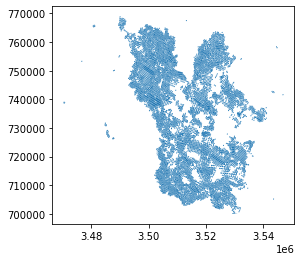

In [6]:
#SCU
scu = fire_over_poly[fire_over_poly['Fire Name']=='SCU LIGHTNING COMPLEX']
#scu.plot()

box = Polygon([(3.47e6,7e5),(3.47e6,7.7e5), (3.55e6,7.7e5), (3.55e6,7e5)])
scu_clipped = gpd.clip(scu, box)
scu_clipped.plot()


In [13]:
#save to geojson
scu_clipped.to_file('./fire_polygons/scu_VIIRS_per_overpass.geojson',driver='GeoJSON')

scu_clipped_daily = combine_per_overpass_polygons_to_daily('scu', 12)
print(scu_clipped_daily)
#scu_clipped_daily.to_file('./fire_polygons/scu_VIIRS_daily_0Z_day_start.geojson',driver='GeoJSON')
scu_clipped_daily.to_file('./fire_polygons/scu_VIIRS_daily_12Z_day_start.geojson',driver='GeoJSON')

#scu_clipped_daily.to_file('./for_Pablo/SHP/scu_VIIRS_daily_0Z_day_start.shp')


['2020-08-16', '2020-08-16', '2020-08-16', '2020-08-16', '2020-08-16', '2020-08-16', '2020-08-17', '2020-08-17', '2020-08-17', '2020-08-17', '2020-08-17', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-18', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-19', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-21', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-22', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-23', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-24', '2020-08-25', '2020-08-25', '2020-08-25', '2020-08-25', '2020-08-25', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-26', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-27', '2020-08-28', '2020-08-28', '2020

# Make the polygons for the test fires

In [14]:
#load in the 2019 file
fire_over_poly = gpd.read_file('AllFires_VIIRS_per_overpass_2019.geojson')

In [17]:
print(len(fire_over_poly))


2569
      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
0          10662156.0            C34  2019-02-13             805.0  36.995278   
1          10663171.0  LONE MOUNTAIN  2019-05-27             737.0  33.808056   
2          10663171.0  LONE MOUNTAIN  2019-06-09            1953.0  33.808056   
3          10663171.0  LONE MOUNTAIN  2019-06-13            2019.0  33.808056   
4          10663171.0  LONE MOUNTAIN  2019-06-21             809.0  33.808056   
...               ...            ...         ...               ...        ...   
2564       10805427.0        204 COW  2019-09-15            2100.0  44.285000   
2565       10806265.0  CHIMNEY CREEK  2019-08-09             746.0  33.323889   
2566       10806265.0  CHIMNEY CREEK  2019-08-09            2050.0  33.323889   
2567       10806265.0  CHIMNEY CREEK  2019-08-10            1851.0  33.323889   
2568       10806265.0  CHIMNEY CREEK  2019-08-10            2031.0  33.323889   

        Lon Fire  Numb

      Incident Number      Fire Name Current Day  Current Overpass   Lat Fire  \
1052       10743078.0  GRANITE GULCH  2019-07-14             734.0  45.178056   
1053       10743078.0  GRANITE GULCH  2019-07-20            1044.0  45.178056   
1054       10743078.0  GRANITE GULCH  2019-07-30            2041.0  45.178056   
1055       10743078.0  GRANITE GULCH  2019-07-31            2022.0  45.178056   
1056       10743078.0  GRANITE GULCH  2019-08-01            1019.0  45.178056   
...               ...            ...         ...               ...        ...   
1113       10743078.0  GRANITE GULCH  2019-10-12             928.0  45.178056   
1114       10743078.0  GRANITE GULCH  2019-10-12             929.0  45.178056   
1115       10743078.0  GRANITE GULCH  2019-10-12            2054.0  45.178056   
1116       10743078.0  GRANITE GULCH  2019-10-13            2035.0  45.178056   
1117       10743078.0  GRANITE GULCH  2019-10-17            2100.0  45.178056   

        Lon Fire  Number of

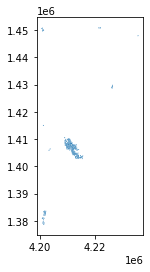

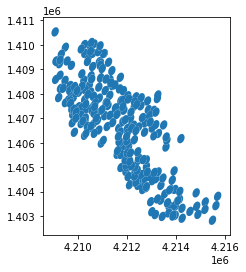

In [26]:
#GRANITE GULCH
gg = fire_over_poly[fire_over_poly['Fire Name']=='GRANITE GULCH']
print(gg)
gg.plot()

box = Polygon([(4.2075e6,1.40e6),(4.2075e6,1.42e6), (4.22e6,1.42e6), (4.22e6,1.40e6)])
gg_clipped = gpd.clip(gg, box)
gg_clipped.plot()

#save per-overpass file
gg_clipped.to_file('./fire_polygons/granite_gulch_VIIRS_per_overpass.geojson',driver='GeoJSON')


gg_clipped_daily = combine_per_overpass_polygons_to_daily('granite gulch', 0)
print(gg_clipped_daily)
gg_clipped_daily.to_file('./fire_polygons/granite_gulch_VIIRS_daily_0Z_day_start.geojson',driver='GeoJSON')

In [6]:
#incidents_all = incidents_all[incidents_all['Fire Name']=='EAST TROUBLESOME']
print(incidents_all[incidents_all['Fire Name']=='RIVERSIDE'])

      Incident Number  Fire Name            First Day    Last Day   Lat Fire  \
1240       11941464.0  RIVERSIDE  2020-09-08 03:54:00  2020-12-03  45.049167   

        Lon Fire  Final Area (ac)        First Day UTC         Last Day UTC  \
1240 -122.062222         138054.0  2020-09-08 10:54:00  2020-12-03 08:00:00   

                 Timezone  
1240  America/Los_Angeles  


In [26]:
#fire_incidents = ['AUGUST COMPLEX','BOBCAT', 'DOLAN', 'HOLIDAY FARM','CREEK', 'LAKE', 'CAMERON PEAK', 'PINE GULCH', 'WILLIAMS FLATS', 'SHADY','PEDRO MOUNTAIN', 'WALKER', '204 COW']
#inci_choose = [0,1,0,0,2,2,0,0,0,0,0,0,0] #choose which fire when there are multiple (need to automate)

#fire_incidents =['EAST TROUBLESOME','RIVERSIDE']
#inci_choose=[0,0]

fire_incidents =['EAST TROUBLESOME']
inci_choose=[0]
#fire_incidents = ['CREEK', 'WILLIAMS FLATS']#, 'LAKE', 'CAMERON PEAK', 'PINE GULCH']
#inci_choose = [2,0]#,2,0,0] #choose which fire when there are multiple (need to automate)
#fire_incidents = ['LAKE']
#inci_choose =[2]

for ii in range(len(fire_incidents)):
    
    print(fire_incidents[ii])
    
    """inci = incidents_all[incidents_all['Fire Name']==fire_incidents[ii]].iloc[inci_choose[ii]]
    print(inci)
    df_save_size = count_overpasses(inci,viirs_all) #count the overpasses between fire start and end date
    print(df_save_size)
    
    area = 0
    final_area = inci['Final Area (ac)']
    idx = 0
    #radii_test = [0.01,0.05,0.1,0.25]
    radii_test=[0.0001]
    
    while (area<0.75*final_area) & (idx<len(radii_test)):
        print(idx)
    
        fire_poly_timeseries = build_polygon_timeseries(df_save_size,inci,0.05)

        fire_poly_timeseries.crs = "EPSG:4326"
        fire_poly_timeseries = fire_poly_timeseries.to_crs(epsg=3347) #put into lambert conformal conic

        #make sure the returned polygons are valid
        fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].buffer(0)
        fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x, rounding_precision=4)))
        fire_poly_timeseries['geometry'] = fire_poly_timeseries['geometry'].apply(lambda y: make_valid(y))
        fire_poly_timeseries['geometry'].apply(lambda z: print(explain_validity(z)))
        fire_poly_timeseries['daily_area'] = fire_poly_timeseries.area/4047 #area in acres
        
        area=fire_poly_timeseries['daily_area'].sum()
        idx=idx+1
        print(area, final_area)
    
    fire_poly_timeseries_plot = fire_poly_timeseries.to_crs('EPSG:4326')
    
    fig = plt.figure(figsize=(15,10))
    ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
    #ax.set_extent([-124, -122, 39.2,40.5])
    fire_poly_timeseries_plot.plot(column = fire_poly_timeseries['Current Day'], ax=ax, cmap='OrRd')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    plt.title(fire_incidents[ii]+ 'With Per Overpass Polygons')
    plt.show()
    
    fire_poly_timeseries.set_geometry(col='geometry', inplace=True) #assign a column to represent geometry
    fire_poly_timeseries.to_file(fire_incidents[ii].lower().replace(' ', '_')+'_VIIRS_per_overpass_2.geojson', driver='GeoJSON')
    """
    day_start_hour =12
    daily_fire_att_poly = combine_per_overpass_polygons_to_daily(fire_incidents[ii],day_start_hour)
    daily_fire_att_poly.set_geometry(col='geometry', inplace=True) #assign a column to represent geometry
    print(daily_fire_att_poly)
    daily_fire_att_poly.to_file('./fire_polygons/'+fire_incidents[ii].lower().replace(' ', '_')+
                                '_VIIRS_daily_'+str(day_start_hour)+'Z_day_start.geojson', driver='GeoJSON')

EAST TROUBLESOME
['2020-10-13', '2020-10-14', '2020-10-14', '2020-10-14', '2020-10-14', '2020-10-14', '2020-10-15', '2020-10-15', '2020-10-15', '2020-10-15', '2020-10-15', '2020-10-15', '2020-10-16', '2020-10-16', '2020-10-16', '2020-10-16', '2020-10-16', '2020-10-16', '2020-10-17', '2020-10-17', '2020-10-18', '2020-10-18', '2020-10-18', '2020-10-18', '2020-10-19', '2020-10-19', '2020-10-19', '2020-10-19', '2020-10-20', '2020-10-20', '2020-10-20', '2020-10-20', '2020-10-21', '2020-10-21', '2020-10-21', '2020-10-21', '2020-10-21', '2020-10-21', '2020-10-22', '2020-10-22', '2020-10-22', '2020-10-22', '2020-10-22', '2020-10-22', '2020-10-23', '2020-10-23', '2020-10-23', '2020-10-23', '2020-10-24', '2020-10-24']
4 seconds
     Local Day                                           geometry  \
0   2020-10-13  POLYGON ((4934021.226 575313.128, 4934016.005 ...   
1   2020-10-14  MULTIPOLYGON (((4936413.977 571601.812, 493640...   
2   2020-10-15  MULTIPOLYGON (((4936476.314 569904.281, 493646...

In [ ]:
#make total polygons using dissolve
fire_incidents = ['AUGUST COMPLEX','BOBCAT', 'DOLAN', 'HOLIDAY FARM','CREEK', 'LAKE', 'CAMERON PEAK', 'PINE GULCH', 'WILLIAMS FLATS', 'SHADY','PEDRO MOUNTAIN', 'WALKER', '204 COW']
inci_choose = [0,1,0,0,2,2,0,0,0,0,0,0,0] #choose which fire when there are multiple (need to automate)

#fire_incidents = ['LAKE']
#inci_choose =[2]

for ii in range(len(fire_incidents)):
    print(fire_incidents[ii])
    daily_fire_poly = gpd.read_file('./fire_polygons/'+fire_incidents[ii].lower().replace(' ', '_')+'_VIIRS_daily.geojson')
    
    tic=time.time()
    total_fire_poly = daily_fire_poly.dissolve(by='Fire Name')
    toc=time.time()
    print(toc-tic)
    total_fire_poly.to_file('./fire_polygons/'+fire_incidents[ii].lower().replace(' ', '_')+'_VIIRS_total.geojson', driver='GeoJSON')

# Helper Functions

In [67]:
#function to get the size of the resulting dataframe
#IN: incidents=the summary table of the incidents (only one incident at a time)
#IN: viirs_all= table of all VIIRS detects
#OUT: df_size= the number of satellite overpasses between start and end times of fire in UTC
def count_overpasses(incidents,viirs_all):
    df_size = 0
    #start and end times of the fire in UTC
    print(type(incidents['First Day UTC']))
    inci_start = np.datetime64(incidents['First Day UTC'], 'D')
    inci_end = np.datetime64(incidents['Last Day UTC'],'D') 

    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                    & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    for day in dates:
        viirs_sub = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        df_size = df_size + len(np.unique(viirs_sub['acq_time']))
    return df_size

In [68]:
def build_polygon_timeseries(df_size,incidents,rad):
    fire_series_new = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size),
                                        'irwinID': np.nan*np.zeros(df_size), 
                                        'Fire Name': np.nan*np.zeros(df_size), 
                                        'Current Day': np.nan*np.zeros(df_size),
                                        'Current Overpass': np.nan*np.zeros(df_size),
                                        'Lat Fire': np.nan*np.zeros(df_size), 
                                        'Lon Fire': np.nan*np.zeros(df_size), 
                                        'Number of NEW VIIRS points': np.nan*np.zeros(df_size), 
                                        'NEW FRP': np.nan*np.zeros(df_size),
                                        'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe

    fire_series_cumu = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                                        'irwinID': np.nan*np.zeros(df_size), 
                                        'Fire Name': np.nan*np.zeros(df_size), 
                                        'Current Day': np.nan*np.zeros(df_size),
                                        'Current Overpass': np.nan*np.zeros(df_size),
                                        'Lat Fire': np.nan*np.zeros(df_size), 
                                        'Lon Fire': np.nan*np.zeros(df_size), 
                                        'Number of TOTAL VIIRS points': np.nan*np.zeros(df_size), 
                                        'NEW FRP': np.nan*np.zeros(df_size),
                                        'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe
    count = 0
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day UTC'], 'D')
    inci_end = np.datetime64(incidents['Last Day UTC'], 'D') 
    
    lat_fire = incidents['Lat Fire']
    lon_fire = incidents['Lon Fire']
    #print(lon_fire, lat_fire)
    
    #pt_start = Point(lon_fire, lat_fire)
    #pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    #name = incidents['Fire Name']
    #print(name)
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    print(dates)
    
    tic=np.datetime64('now') #to time how long the code takes
   
    for day in dates: #loop over the days
        print(day)
        viirs_day = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        overpasses = np.unique(viirs_day['acq_time'])
        
        for over in overpasses: #loop over the overpasses
            #print(over)
            viirs_over = viirs_day.iloc[np.where(viirs_day['acq_time']==over)[0]] # all points associated with an overpass
            lat = viirs_over['latitude'].values
            lon = viirs_over['longitude'].values
            viirs_tups = [list((lon[i], lat[i])) for i in range(len(lat))]
    
            poly_lats, poly_lons = build_today_polygon(lat, lon, lat_old, lon_old, rad)
        
            #get the new points and the cumulative points
            #poly_tups_cumulative = [list((lon_cumulative[i], lat_cumulative[i])) for i in range(len(lon_cumulative))]
            poly_tups_new = [list((poly_lons[i], poly_lats[i])) for i in range(len(poly_lons))]
            
            
            if day==dates[0] and over==overpasses[0]: #if it's the first day of the fire
                #get the cumulative stuff 
                lat_cumulative = np.append(lat_old, poly_lats)
                lon_cumulative = np.append(lon_old, poly_lons)
                poly_tups_cumulative = [list((lon_cumulative[i], lat_cumulative[i])) for i in range(len(lon_cumulative))]
                inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups_cumulative] #inds where we grab FRP
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
                #make a shape around the cumulative points, buffer by 300m (0.0027027 degrees ~0.003 degrees) NEED TO DIVIDE BY 2
                shape_new_save = MultiPoint(poly_tups_cumulative).buffer(0.001763092448)#.convex_hull #the full shape so far
                fire_series_new.iloc[count] = [incidents['Incident Number'],\
                                               incidents['irwinID'][2:38],\
                                       incidents['Fire Name'],\
                                       day, over,\
                                    lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]
                fire_series_cumu.iloc[count] = [incidents['Incident Number'],\
                                                incidents['irwinID'][2:38],\
                                       incidents['Fire Name'],\
                                       day, over, \
                                    lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]     
                    
                count=count+1
                
            elif len(poly_tups_new)!=0: #if we are adding new points
                inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups_new] #inds where we grab FRP
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
                shape_new = MultiPoint(poly_tups_new).buffer(0.001763092448)
                shape_cumu = fire_series_cumu['geometry'].iloc[count-1]
                shape_new_save = shape_new.difference(shape_cumu)
                fire_series_new.iloc[count] = [incidents['Incident Number'],\
                                               incidents['irwinID'][2:38],\
                                       incidents['Fire Name'],\
                                       day, over, \
                                               lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new_save]
                fire_series_cumu.iloc[count] = [incidents['Incident Number'],\
                                                incidents['irwinID'][2:38],\
                                       incidents['Fire Name'],\
                                       day, over,  \
                                               lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new.union(shape_cumu)]     
                    
                count=count+1
                
            lat_cumulative = np.append(lat_old, poly_lats)
            lon_cumulative = np.append(lon_old, poly_lons)
            lat_old=lat_cumulative
            lon_old=lon_cumulative
            
    
    toc = np.datetime64('now') #to time how long the code takes
    print(str(toc-tic)+' seconds elapsed')
    
    #drop null geometries
    fire_series_new = fire_series_new.drop(np.where(fire_series_new['geometry']==None)[0])

    return fire_series_new

In [69]:
#lat_old and lon_old are the detects used to build the prev version of today's polygon
def build_today_polygon(lats, lons, lats_old, lons_old, bf):
    tups_old = [list((lons_old[i], lats_old[i])) for i in range(len(lats_old))]
    shape_old_buff = MultiPoint(tups_old).convex_hull.buffer(bf)
    
    #find the points that are inside the buffer
    pairs = zip(lons, lats)
    lat_new = []
    lon_new = []
    
    xs, ys = shape_old_buff.exterior.xy #get the edges of the buffered shape
    poly_path = Path(np.stack([xs, ys], axis=1)) #make them into a path
    poly_path_contains = poly_path.contains_points(np.stack([lons,lats],axis=1)) #get the points that are in the shape REPLACES FOR LOOP

    #grab the new points
    lat_new =lats[np.where(poly_path_contains==True)[0]]
    lon_new =lons[np.where(poly_path_contains==True)[0]]


    if (len(lat_new)-len(lats_old))>0: #if we are adding points 
        #print('Time for recursive call')
        return build_today_polygon(lats, lons, lat_new, lon_new, bf)
    else:
        return lat_new, lon_new #MAY WANT TO RETURN A BUFFERED VERSION OF THE POLYGON
    

In [70]:
#uses max to combine the polygons, day starts at day_start_hour
def combine_per_overpass_polygons_to_daily(fire, day_start_hour):
    # load in the PER OVERPASS polygons and attributes
    per_overpass_fire = gpd.read_file('./fire_polygons/'+fire.lower().replace(' ','_')+'_VIIRS_per_overpass.geojson') #polygons only

    daystrings = [per_overpass_fire['Current Day'].iloc[i]  for i in range(len(per_overpass_fire))]
    timestrings = [str(int(per_overpass_fire['Current Overpass'].iloc[i])).zfill(4) for i in range(len(per_overpass_fire))]

    datetime_strings = [daystrings[i]+'T'+timestrings[i][0:2]+':'+timestrings[i][2:4] for i in range(len(per_overpass_fire))]
    datetimes = np.array(datetime_strings,dtype='datetime64')

    current_day = [] #if observed hour>day_start_hour, current day, else previous day
    for ii in range(len(datetimes)):
        time_compare = np.datetime64(daystrings[ii]+'T'+str(day_start_hour).zfill(2)+':00')
        if datetimes[ii]>= time_compare:
            current_day.append(daystrings[ii])
        else:
            current_day.append(str(np.datetime64(daystrings[ii])-np.timedelta64(1,'D')))
    print(current_day)
    per_overpass_fire['Local Day'] = current_day
    tic = np.datetime64('now')
    daily_fire_dataframe = per_overpass_fire.dissolve(by='Local Day', aggfunc='max',as_index=False)
    toc = np.datetime64('now')
    print(toc-tic)
    
    return daily_fire_dataframe

## Testing

In [ ]:
fire = 'LAKE'
fire_daily = combine_per_overpass_polygons_to_daily(fire,12)
print(fire_daily)

In [ ]:
#uses max to combine the polygons
def combine_per_overpass_polygons_to_daily_old(fire):
    print(fire.upper(), fire.lower())
    # load in the PER OVERPASS polygons and attributes
    per_overpass_fire = gpd.read_file(fire.lower().replace(' ','_')+'_VIIRS_per_overpass.geojson') #polygons only
    fire_inds = np.where(per_overpass_fire['Fire Name']==fire.upper())[0];
    
    datestrings = [per_overpass_fire['Current Day'].iloc[i]+ ' '+\
               str(int(per_overpass_fire['Current Overpass'].iloc[i])).zfill(4) for i in range(len(fire_inds))]
    
    tic = np.datetime64('now')
    daily_fire_dataframe = per_overpass_fire.dissolve(by='Current Day', aggfunc='max',as_index=False)
    toc = np.datetime64('now')
    print(toc-tic)
    
    return daily_fire_dataframe

In [ ]:
df_lake_new = gpd.read_file('lake_VIIRS_per_overpass_2.geojson')
df_lake_new.plot()

In [ ]:
df_lake= gpd.read_file('./fire_polygons/lake_VIIRS_per_overpass.geojson')
df_lake.plot()